<b>Autor> </b>Matthias Titze, s0563413

### Bibliotheken Importieren

In [25]:
# Standard library
import os
import math
import random
# Dataframe handling
import numpy as np
import pandas as pd
from scipy import stats
# Matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.patches as mp
%matplotlib inline
# Seaborn plots
import seaborn as sns
# Hide warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Plotly via cufflinks
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import cufflinks as cf
init_notebook_mode(connected=True)
cf.go_offline()

### Hilfsfunktionen   
zur Erstellung von Kontingenztabellen

In [4]:
def calculate_row_total(df_counts):
    # Add a column for the row total and make sure the value is of type integer.
    df_counts['row_total'] = df_counts.sum(axis=1).astype('int')
    return df_counts

In [5]:
def calculate_row_percentage_table(df_counts):
    # We start to calculate the percentage table by copying the total count values table.
    df_percents = df_counts.copy()
    # Now do a percentage calculation row by row (unsing the row total as a dvider).
    for row in df_percents.index:
        # For precise division (and storing results) we convert the colum values into floats.
        df_percents.loc[row] = df_percents.loc[row].astype('float')
        # Now interate through the columns of the row and calculate the percent in relation to the row total.
        for column in df_percents.columns:
            percentage = df_percents.at[row, column] / df_percents.at[row, 'row_total']
            df_percents.at[row, column] = percentage
        # The total column is now 100 percent.
        df_percents.at[row, 'row_total'] = 1
    
    return df_percents

In [6]:
def calculate_column_total(df_counts):
    # Calculate the total of each new colum and make sure the value is of type integer.
    for column in df_counts.columns:
        df_counts.at['col_total',column] = df_counts[column].sum()
        df_counts[column] = df_counts[column].astype('int')
        
    return df_counts

In [7]:
def calculate_column_percentage_table(df_counts):
    # We start to calculate the percentage table by copying the total count values table.
    df_percents = df_counts.copy()
    # Now do a percentage calculation column by column (unsing the column total as a dvider).
    for column in df_percents.columns:
        # For precise division (and storing results) we convert the colum values into floats.
        df_percents[column] = df_percents[column].astype('float')
        # Now interate through the rows of the column and calculate the percent in relation to the column total.
        for row in df_percents.index:
            percentage = df_percents.at[row, column] / df_percents.at['col_total', column]
            df_percents.at[row, column] = round(percentage, 3)
        # The total row is now 100 percent.
        df_percents.at['col_total', column] = 1

    return df_percents

### Hilfsfunktionen   
zur Berechnung von Chi2

In [8]:
def calculate_crosstable_expected(df_crosstable_total):
    '''Calculates the expected total occurances for a given crosstable. This is required for Chi2 tests.'''
    # Copy the real occurences table as a starting table structure. We want to replace the values.
    df_crosstable_expect = df_crosstable_total.copy()
    # For precise division (and storing results) we convert the colum values into floats.
    df_crosstable_expect = df_crosstable_expect.astype('float')
    # Get the dimenaions of the table and find the sum (all) row and colum.
    row_count = df_crosstable_expect.index.size
    column_count = df_crosstable_expect.columns.size
    total_sum = df_crosstable_total.iat[row_count - 1, column_count - 1]
    # Now interate through each (but the total) cell and calculate the expected occurencies.
    for row_index in range(row_count - 1):
        for column_index in range(column_count - 1):
            row_sum = df_crosstable_total.iat[row_index, column_count - 1]
            column_sum = df_crosstable_total.iat[row_count - 1, column_index]
            # Calculate the expected occurrencies.
            df_crosstable_expect.iat[row_index, column_index] = round((row_sum * column_sum) / total_sum, 2)
        
    return df_crosstable_expect

In [9]:
def calculate_crosstable_difference(df_crosstable_total, df_crosstable_expect):
    '''Calculates the difference between the expected and real total occurances for a given crosstable.
    This is required for Chi2 tests.'''
    # Copy the expected occurences table as a starting table structure. We want to replace the values.
    df_crosstable_diff = df_crosstable_expect.copy()
    # Drop the total row and colum, as we do not need it anymore.
    df_crosstable_diff.drop('All', axis=1, inplace=True)
    df_crosstable_diff.drop('All', axis=0, inplace=True)
    # Get the dimenaions of the target table.
    row_count = df_crosstable_diff.index.size
    column_count = df_crosstable_diff.columns.size
    # Now interate through each cell and calculate the difference between the two occurrency tables.
    for row_index in range(row_count):
        for column_index in range(column_count):
            df_crosstable_diff.iat[row_index, column_index] = \
            df_crosstable_total.iat[row_index, column_index] - df_crosstable_expect.iat[row_index, column_index]
   
    return df_crosstable_diff

In [10]:
def calculate_crosstable_chi2(df_crosstable_diff, df_crosstable_expect):
    '''Calculates Chi2 from a table of expected values and a table holding the differences from these values.'''
    chi2 = 0
    row_count = df_crosstable_diff.index.size
    column_count = df_crosstable_diff.columns.size
    # Now interate through each cell and add to the chi2 value.
    for column_index in range(column_count):
        for row_index in range(row_count):
            difference = df_crosstable_diff.iat[row_index, column_index]
            expected = df_crosstable_expect.iat[row_index, column_index]
            chi2_add = math.pow(difference, 2) / expected
            chi2 = chi2 + chi2_add
            
    return chi2

In [101]:
def calculate_crosstable_contingency_pearson(df_crosstable_total, chi2, sigma):
    # Table dimensions without the total row or column.
    dim_x = df_crosstable_total.index.size - 1;
    dim_y = df_crosstable_total.columns.size - 1;
    # Number of samples found in the lower roght corner.
    n = df_crosstable_total.iat[dim_x, dim_y]
    # Normalized contingency coefficient.
    c_norm = math.sqrt(chi2 / (chi2 + n))
    # Smallest dimension of table.
    k = dim_x if (dim_x < dim_y) else dim_y
    # Maximum value c can reach.
    c_max = math.sqrt((k - 1) / k)
    # Corrected value for c fitting in range 0-1.
    c_corr = c_norm / c_max
    # Degree of freedom needed for chi2.
    deg_free = (dim_x - 1) * (dim_y - 1)
    # Find significant chi2 value for the chosen a significance level.
    chi2_significance = stats.chi2.isf(sigma, deg_free)
    # Create dataframe as a nice package.
    df_corr = pd.DataFrame(index=['Chi2','C_norm','C_max','C_corr','n_samples', 'k_min',
                                  'degree_free','sigma','Chi2_significant'], columns=['values'])
    df_corr.at['Chi2','values'] = chi2
    df_corr.at['C_norm','values'] = c_norm
    df_corr.at['C_max','values'] = c_max
    df_corr.at['C_corr','values'] = c_corr
    df_corr.at['n_samples','values'] = n
    df_corr.at['k_min','values'] = k
    df_corr.at['degree_free','values'] = deg_free
    df_corr.at['sigma','values'] = sigma
    df_corr.at['Chi2_significant','values'] = chi2_significance
    return df_corr

### Plot-Funktionen

In [12]:
def plot_obesity_barstack(x_title, df_bmi_percent):
    # Values of each group.
    bars0 = df_bmi_percent.loc['25-30'].tolist()
    bars1 = df_bmi_percent.loc['30-35'].tolist()
    bars2 = df_bmi_percent.loc['35-40'].tolist()
    bars3 = df_bmi_percent.loc['40+'].tolist()
    # Heights of stacked base bars.
    bars01 = (df_bmi_percent.loc['25-30'] + df_bmi_percent.loc['30-35']).tolist()
    bars012 = (df_bmi_percent.loc['25-30'] + df_bmi_percent.loc['30-35'] + df_bmi_percent.loc['35-40']).tolist()

    # The position of the bars on the x-axis.
    r = range(df_bmi_percent.columns.size)
    # Names of the x-axis groups and bar width
    names = df_bmi_percent.columns.tolist()
    barWidth = 1
    plt.figure(1, figsize=(20,8))

    # Create and stack bars on top of each other.
    plt.bar(r, bars0, color='#9999ff', edgecolor='white', width=barWidth)
    plt.bar(r, bars1, bottom=bars0, color='#70dbdb', edgecolor='white', width=barWidth)
    plt.bar(r, bars2, bottom=bars01, color='#ff9966', edgecolor='white', width=barWidth)
    plt.bar(r, bars3, bottom=bars012, color='#adad85', edgecolor='white', width=barWidth)

    # Custom X axis.
    plt.xticks(r, names, fontsize=12)
    plt.xlabel(x_title)

    # Legend for stacked bar colors.
    patch0 = mp.Patch(color='#9999ff', label='25-30 overweight')
    patch1 = mp.Patch(color='#70dbdb', label='30-35 obese 1')
    patch2 = mp.Patch(color='#ff9966', label='35-40 obese 2')
    patch3 = mp.Patch(color='#adad85', label='40+   obese 3')
    plt.legend(handles=[patch3, patch2, patch1, patch0])

    # Show graphic.
    plt.show()

In [154]:
def plot_pie_chart_1(title, list_labels, list_values, figsize, colormap):
    plt.figure(1, figsize=figsize)
    cmap = plt.get_cmap(colormap)
    colors = [cmap(i) for i in np.linspace(0, 1, 8)]
    plt.pie(list_values, labels=list_labels, autopct='%1.1f%%',
            shadow=True, colors=colors, textprops=dict(color="black", fontsize=14))
    plt.suptitle(title, fontsize=20)

def plot_pie_chart_2(title, dataframe, labels_column, values_column, figsize, colormap):
    list_labels = dataframe[labels_column].tolist()
    list_values = dataframe[values_column].tolist()
    plot_pie_chart_1(title, list_labels, list_values, figsize, colormap)

![title](02_data_extra/nhanes_logo_image.jpg)

### Daten Importieren

In [13]:
path_input = os.path.join('00_data_input')
path_output = os.path.join('03_data_output')
path_categ = os.path.join(path_output, 'nhanes_categ.csv')

In [46]:
df_categ = pd.read_csv(path_categ)
df_categ.head()

id  CODE_status  CM_height  KG_weight  KG_M2_bmi  \
0  41475            3      154.7      138.9      58.04   
1  41476            1      120.4       22.0      15.18   
2  41477            1      167.1       83.9      30.05   
3  41478            1        NaN       11.5        NaN   
4  41479            1      154.4       65.7      27.56   

   CODE_bmi_category_youth  BINARY_gender  YEARS_age  CODE_race  \
0                      NaN              2         62          5   
1                      NaN              2          6          5   
2                      NaN              1         71          3   
3                      NaN              2          1          3   
4                      NaN              1         52          1   

   CODE_race_extended         ...           CAT2_age  CAT_bmi  LAB_bmi  \
0                 NaN         ...              60-69      4.0      40+   
1                 NaN         ...              01-09     -1.0    10-18   
2                 NaN         ...              70-79      2.0    30-35   
3                 NaN         ...              01-09      NaN  unknown   
4                 NaN         ...              50-59      1.0    25-30   

      STR_bmi  CAT1_race  CAT2_race  CAT_houshold_education  \
0      obese3   otherOld      other                       4   
1  underweigt   otherOld      other                       5   
2      obese1      white      white                       3   
3     unknown      white      white                       2   
4  overweight    mexican    mexican                       1   

   LAB_houshold_education  CAT_income_houshold  LAB_income_houshold  
0             4_AA-Degree                  6.0             025-035K  
1              5_College+                 12.0                100+K  
2            3_Highschool                  5.0             020-025K  
3           2_<12th-Grade                  3.0             010-015K  
4            1_<9th-Grade                  8.0             045-055K  

[5 rows x 38 columns]

# <font color='#0099ff'>BMI</font><font color='grey'> und </font><font color='#0099ff'>Einkommen</font>  
Die Untersuchung einer Korrelation von Body-Mass-Index und Einkommen ist der Ausgangspunkt für die Erforschung von sozioökonomischen Faktoren, welche in einem Zusammenhang mit der grassierenden Fettleibigkeit in den USA stehen könnten. Ähnlich wie zuvor mit den Daten aus dem Food Atlas, wird hier nun über den NHANES-Datensatz zunächst das Einkommen der Haushalte als Kernindikator herausgegriffen und in Beziehung zum BMI gesetzt.  

Beide Datenfelder sind über die Identifikationsnummer des untersuchten Teilnehmers verknüpft und wurden zuvor kategorisiert (Klassenbildung). Es handelt sich also um diskrete Daten mit Ordinalskalen. Somit lassen sich die absoluten Häufigkeiten der jeweiligen Merkmalsausprägungen zählen. Daraus ist eine Kontingenztabelle mit m Reihen für die BMI-Klassen und n Spalten für die Einkommensgruppen zu erstellen. Mittels dieser Tabelle lassen sich schließlich mit Chi-Quadrat-Test die Unabhängigkeit der Variablen nachweisen oder aber Beziehungen erkennen.  

#### Hypothesen   
>Als Hypothesenpaar für diese Untersuchung werden aufgestellt:  
<b>Nullhypothese H0:</b> Übergewicht und Fettleibigkeit korrelieren negativ mit Einkommen. Das heißt, mit sinkenden Einkommen steigt die Wahrscheinlichkeit für ungesundes Körpergewicht.  
<b>Alternativhypothese H1:</b> Übergewicht und Einkommen korrelieren nicht. Es besteht kein erkennbarer Zusammenhang zwischen Fettleibigkeit und diesem sozioökonomischen Indikator.

#### Selektion der Daten
Wir wählen zunächst die kategorisierten Tabellenspalten für BMI und Haushaltseinkommen aus.  
<b>BMI:</b> Es stehen folgende Merkmalsausprägungen für den Body-Mass-Index zur Verfügung: {10-18; 18-25; 25-30; 30-35; 35-40; 40+; unbekannt}.  
Diese Ausprägungen sind geordnet aber nicht in streng gleichförmigen Intervallen. Sie repräsentieren die gesundheitlich relevanten Kategorien: Untergewicht, Normalgewicht, Übergewicht, Fettleibigkeit 1-3. Die Benennungen der Intervalle weisen scheinbar Überschneidungen auf. Diese existieren jedoch nur Aufgrund abgekürzter Schreibweise (siehe Abschnitt zur Kategorisierung der Daten).  
<b>Einkommen:</b> Die Einkommensklassen beschreiben Intervalle mit unterschiedlicher (ansteigender) Breite. Dazu kommt wiederum der nach oben offene Maximalwert "100+K" sowie die weniger präzisen Ausweichkategorien "<20K" und ">20K". Also: {000-005K; 005-010K; 010-015K; 015-020K; 020-025K; 025-035K; 035-045K; 045-055K; 055-065K; 065-075K; 075-100K; 100+K; <20K; >20K; unbekannt}.  

<b>Fehlende Daten:</b> Von den 47873 Datenreihen enthalten einige die nicht aussagekräftigen "unbekannt" Einträge, welche ausgeschlossen werden. Damit reduziert sich der Datensatz auf 41800 Stichproben. Diese Menge scheint immer noch umfassend genug und deutlich weniger verzerrt als eine mit fiktiven Daten aufgefüllte Tabelle. Da die Einkommensklassen "<20K" und ">20K" ebenso wenig Auskunft geben und zudem die anderen Intervalle überlagern, müssen diese eventuell auch aus weiteren Test heraus genommen werden. Dies würde den Datensatz auf 39752 Reihen verkleinern.

In [15]:
# Select income and bmi columns from the categorized dataframe.
df_bmi_income = df_categ[['id','LAB_income_houshold','LAB_bmi']].copy()
# Drop rows with missing values.
df_bmi_income = df_bmi_income[df_bmi_income['LAB_income_houshold'] != 'unknown']
df_bmi_income = df_bmi_income[df_bmi_income['LAB_bmi'] != 'unknown']
# Rename the columns of the new dataframe for easier reding.
df_bmi_income.rename(columns={'LAB_bmi':'bmi','LAB_income_houshold':'houshold_income'}, inplace=True)
df_bmi_income.head()

id houshold_income    bmi
0  41475        025-035K    40+
1  41476           100+K  10-18
2  41477        020-025K  30-35
4  41479        045-055K  25-30
5  41480        035-045K  10-18

#### Kontingenztabellen BMI & Einkommensgruppen   
Der selektierte Datensatz kann über Pivotieren in eine Kontingenztabelle umgewandelt werden. Als Reihen werden nun die BMI-Klassen und als Spalten die Einkommensgruppen abgebildet. Die jeweiligen Ausprägungen werden dabei zu Zählungen der Häufigkeiten aggregiert. Des weiteren können der Werte über alle Reihen und Spalten aufsummiert werden. Eine weitere Tabelle der relativen Häufigkeiten erhalten wir über Division der absoluten Häufigkeiten durch die Spaltensumme. Dieser Tabelle ist schließlich zu entnehmen, wie in jeder Einkommensgruppe, die BMI-Klassen prozentual verteilt sind.

In [16]:
# Aggregate the count of observations for each income group and bmi class.
df_bmi_income_stats = df_bmi_income.groupby(['houshold_income','bmi']).count()
df_bmi_income_stats = df_bmi_income_stats.reset_index()
# Rename the id column as it is now the count of the samples.
df_bmi_income_stats.rename(columns={'id':'count'}, inplace=True)
# Transform the grouped table to spread out the variables along two axes (pivoting).
df_bmi_income_stats = df_bmi_income_stats.pivot(values='count',
                                                index='bmi',
                                                columns='houshold_income')
# Calculate the total of each row and column.
df_bmi_income_stats = calculate_column_total(df_bmi_income_stats)
df_bmi_income_stats = calculate_row_total(df_bmi_income_stats)
df_bmi_income_stats

houshold_income  000-005K  005-010K  010-015K  015-020K  020-025K  025-035K  \
bmi                                                                           
10-18                 282       406       577       647       752      1050   
18-25                 325       548       801       837       999      1505   
25-30                 210       393       732       704       854      1202   
30-35                 135       284       437       462       500       759   
35-40                  52       116       243       206       242       354   
40+                    59       131       156       162       197       312   
col_total            1063      1878      2946      3018      3544      5182   

houshold_income  035-045K  045-055K  055-065K  065-075K  075-100K  100+K  \
bmi                                                                        
10-18                 770       593       442       368       736   1412   
18-25                1148       993       731       531      1167   2250   
25-30                1004       810       605       520       912   1587   
30-35                 625       472       363       317       566    845   
35-40                 282       235       183       143       245    322   
40+                   209       163       105        90       167    210   
col_total            4038      3266      2429      1969      3793   6626   

houshold_income  <020K  >020K  row_total  
bmi                                       
10-18              121    224       8380  
18-25              149    429      12413  
25-30              118    424      10075  
30-35               80    282       6127  
35-40               34     91       2748  
40+                 27     69       2057  
col_total          529   1519      41800

In [17]:
# Now use the column total as a divider for each row to calculate percentages.
df_bmi_income_percent = calculate_column_percentage_table(df_bmi_income_stats).drop('row_total', axis=1)
df_bmi_income_percent

houshold_income  000-005K  005-010K  010-015K  015-020K  020-025K  025-035K  \
bmi                                                                           
10-18               0.265     0.216     0.196     0.214     0.212     0.203   
18-25               0.306     0.292     0.272     0.277     0.282     0.290   
25-30               0.198     0.209     0.248     0.233     0.241     0.232   
30-35               0.127     0.151     0.148     0.153     0.141     0.146   
35-40               0.049     0.062     0.082     0.068     0.068     0.068   
40+                 0.056     0.070     0.053     0.054     0.056     0.060   
col_total           1.000     1.000     1.000     1.000     1.000     1.000   

houshold_income  035-045K  045-055K  055-065K  065-075K  075-100K  100+K  \
bmi                                                                        
10-18               0.191     0.182     0.182     0.187     0.194  0.213   
18-25               0.284     0.304     0.301     0.270     0.308  0.340   
25-30               0.249     0.248     0.249     0.264     0.240  0.240   
30-35               0.155     0.145     0.149     0.161     0.149  0.128   
35-40               0.070     0.072     0.075     0.073     0.065  0.049   
40+                 0.052     0.050     0.043     0.046     0.044  0.032   
col_total           1.000     1.000     1.000     1.000     1.000  1.000   

houshold_income  <020K  >020K  
bmi                            
10-18            0.229  0.147  
18-25            0.282  0.282  
25-30            0.223  0.279  
30-35            0.151  0.186  
35-40            0.064  0.060  
40+              0.051  0.045  
col_total        1.000  1.000

### Visuelle Analyse von BMI in Einkommensgruppen   
Für die Untersuchung der Fettleibigkeit sind vor allem die BMI-Gruppen "25-30" (Übergewicht), "30-35" (Adipositas 1), 35-40" (Adipositas 2) und "40+" (Adipositas 3) interessant. Sie werden aus der Kontingenztabelle der prozentualen Verteilung gelesen und als gestapelte Balken für jede Einkommensgruppe dargestellt. 
<b>Das Resultat überrascht:</b> Zunächst wird das Ausmaß des Problems deutlich - in den USA liegt der Anteil an Menschen mit krankhafter Fettleibigkeit im Schnitt bei knapp 30%. Werden übergewichtige Personen hinzu gezählt, erreicht der Anteil fast 50%. Eine Anstieg des prozentualen Anteils von übergewichtigen oder fettleibigen Menschen mit sinkendem Einkommen ist in keiner Form zu erkennen. Stattdessen finden wir in den untersten Einkommensklassen sogar einen Rückgang. Dies ist bei einem Jahreseinkommen von unter 5.000 vielleicht nicht ganz verwunderlich. In der Spanne von 10.000-75.000 scheint die prozentuale Verteilung von allen betrachteten BMI-Klassen jedoch eher gleichförmig zu verlaufen. Jenseits von kleineren Schwankungen ist kein Trend auszumachen. Erst ab 75.000 sehen wir einen minimalen und ab 100.000 einen deutlichen Rückgang der Fettleibigkeit.  
<b>Besonderheiten:</b> sind in den übergreifenden Einkommensgruppen "<20K" und ">20K" zu finden. Hier scheint sich der vermutete Zusammenhang eher abzubilden. Bei jedoch gerade einmal 141 dargestellten Proben in der viel breiteren Einkommensklasse "<20K", sollte dieser Beobachtung jedoch nicht zu viel Bedeutung beigemessen werden.

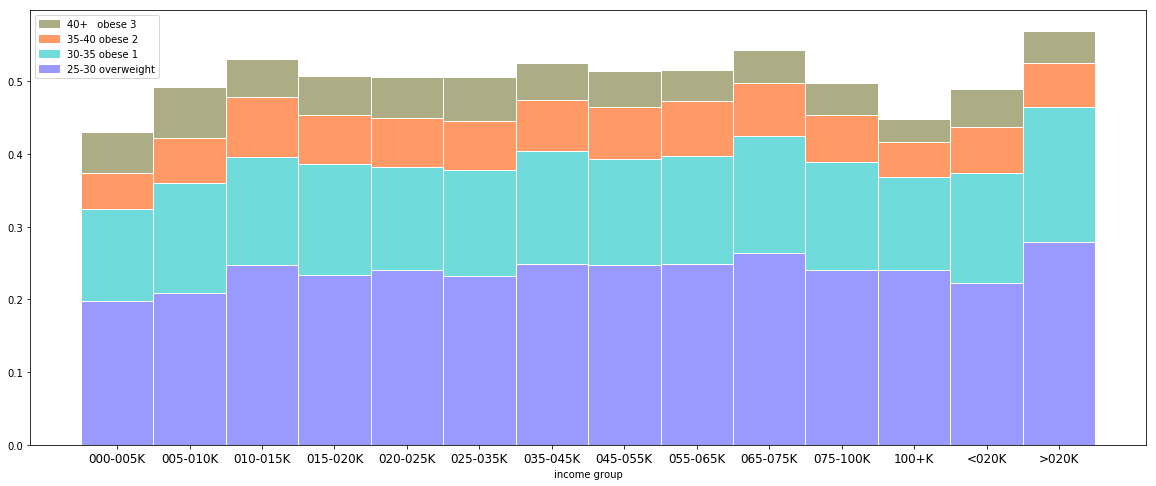

In [18]:
plot_obesity_barstack('income group', df_bmi_income_percent)

### Chi2-Test für BMI und Einkommensgruppe  
Um einen etwaigen Zusammenhang zwischen Fettleibigkeit und Einkommensklasse weiter mit statistischen Methoden zu erforschen, soll der Chi-Quadrat-Test zur Anwendung kommen. Dieser bietet sich zunächst an, da hier mit kategorischen Daten und einer Kontingenztabelle gearbeitet wurde. Der Test kann nur nachweisen ob die zwei Merkmale voneinander im Grundsatz statistisch unabhängig sind. Er basiert auf der Annahme, dass die zu erwartenden Werte innerhalb einer Kontingenztabelle über die Randsummen berechnet werden können. Wir betrachten nun die Differenzen zu den durch die Stichproben erhalten Werten und berechnen Chi-Quadrat nach folgender Formel:  
$$\chi^2 = \sum_{i=1}^{j}\sum_{k=1}^{m}\frac{(h_{ij} - \tilde{h_{ij}})^2}{\tilde{h_{ij}}}$$
>Die Hypothesen müssen also entsprechend der Aussagekraft des Tests präzisiert und umgestellt werden:  
<b>Nullhypothese H0:</b> Übergewicht und Fettleibigkeit sind stochastisch unabhängig.  
<b>Alternativhypothese H1:</b> Übergewicht bzw. Fettleibigkeit und Einkommensklasse sind voneinander abhängige Variablen.   
<b>Sigma:</b> Gewählt wird ein Signifikanzniveau von 5% (p = 0.05).

#### Kontingenztabelle und erwartete Häufigkeiten  
Die Kontingenztabelle für die Merkmale, Fettleibigkeit und Einkommensgruppe wurde bereits für die visuelle Analyse erstellt. Jedoch scheint hier eine weitere Angleichung der Qualität der Merkmalsausprägungen angebracht. Aus diesem Grund werden die wenig präzisen Einkommensgruppen "<20K" und ">20K" aus dem Test entfernt. Die Gesamtsumme der Stichproben fällt somit auf immer noch genügende 39.752 Ausprägungen. Aus den Randsummen der Kontingenztabelle werden die erwarteten Häufigkeiten nach der folgenden Formel ermittelt:   

$$\tilde{h_{ij}}=\frac{h_{i*}h_{*j}}{n}$$   

Somit lässt sich eine weitere Tabelle für die erwarteten Werte und schließlich eine dritte für die Differenz von Stichprobe und Erwartung aufsetzen. Diese beiden Tabellen werden schließlich genutzt um Chi-Quadrat entsprechend obiger Formel zu ermitteln.

In [19]:
# Drop the values which do not fit in the same categorization class and would distort the calculation.
df_bmi_income_redux = df_bmi_income[(df_bmi_income['houshold_income'] != '<020K') & \
                                    (df_bmi_income['houshold_income'] != '>020K')]
# Easier way to create the needed contingency (cross)table (via library function).
df_bmi_income_crosstable_total = pd.crosstab(df_bmi_income_redux['bmi'], df_bmi_income_redux['houshold_income'],
                                             margins=True)
df_bmi_income_crosstable_total

houshold_income  000-005K  005-010K  010-015K  015-020K  020-025K  025-035K  \
bmi                                                                           
10-18                 282       406       577       647       752      1050   
18-25                 325       548       801       837       999      1505   
25-30                 210       393       732       704       854      1202   
30-35                 135       284       437       462       500       759   
35-40                  52       116       243       206       242       354   
40+                    59       131       156       162       197       312   
All                  1063      1878      2946      3018      3544      5182   

houshold_income  035-045K  045-055K  055-065K  065-075K  075-100K  100+K  \
bmi                                                                        
10-18                 770       593       442       368       736   1412   
18-25                1148       993       731       531      1167   2250   
25-30                1004       810       605       520       912   1587   
30-35                 625       472       363       317       566    845   
35-40                 282       235       183       143       245    322   
40+                   209       163       105        90       167    210   
All                  4038      3266      2429      1969      3793   6626   

houshold_income    All  
bmi                     
10-18             8035  
18-25            11835  
25-30             9533  
30-35             5765  
35-40             2623  
40+               1961  
All              39752

In [20]:
# Calculate the expected values for the contingency table.
df_bmi_income_crosstable_expect = calculate_crosstable_expected(df_bmi_income_crosstable_total)
df_bmi_income_crosstable_expect

houshold_income  000-005K  005-010K  010-015K  015-020K  020-025K  025-035K  \
bmi                                                                           
10-18              214.86    379.60    595.47    610.02    716.34   1047.43   
18-25              316.48    559.12    877.09    898.52   1055.12   1542.79   
25-30              254.92    450.37    706.49    723.75    849.89   1242.70   
30-35              154.16    272.36    427.24    437.68    513.97    751.52   
35-40               70.14    123.92    194.39    199.14    233.85    341.93   
40+                 52.44     92.64    145.33    148.88    174.83    255.63   
All               1063.00   1878.00   2946.00   3018.00   3544.00   5182.00   

houshold_income  035-045K  045-055K  055-065K  065-075K  075-100K    100+K  \
bmi                                                                          
10-18              816.19    660.15    490.97    397.99    766.67  1339.30   
18-25             1202.20    972.36    723.16    586.21   1129.26  1972.70   
25-30              968.36    783.23    582.50    472.19    909.61  1588.99   
30-35              585.61    473.65    352.26    285.55    550.08   960.93   
35-40              266.44    215.50    160.28    129.92    250.28   437.21   
40+                199.20    161.11    119.82     97.13    187.11   326.87   
All               4038.00   3266.00   2429.00   1969.00   3793.00  6626.00   

houshold_income      All  
bmi                       
10-18             8035.0  
18-25            11835.0  
25-30             9533.0  
30-35             5765.0  
35-40             2623.0  
40+               1961.0  
All              39752.0

In [21]:
# Calculate the discrepency between real and expected values.
df_bmi_income_crosstable_diff = calculate_crosstable_difference(df_bmi_income_crosstable_total,
                                                                df_bmi_income_crosstable_expect)
df_bmi_income_crosstable_diff

houshold_income  000-005K  005-010K  010-015K  015-020K  020-025K  025-035K  \
bmi                                                                           
10-18               67.14     26.40    -18.47     36.98     35.66      2.57   
18-25                8.52    -11.12    -76.09    -61.52    -56.12    -37.79   
25-30              -44.92    -57.37     25.51    -19.75      4.11    -40.70   
30-35              -19.16     11.64      9.76     24.32    -13.97      7.48   
35-40              -18.14     -7.92     48.61      6.86      8.15     12.07   
40+                  6.56     38.36     10.67     13.12     22.17     56.37   

houshold_income  035-045K  045-055K  055-065K  065-075K  075-100K   100+K  
bmi                                                                        
10-18              -46.19    -67.15    -48.97    -29.99    -30.67   72.70  
18-25              -54.20     20.64      7.84    -55.21     37.74  277.30  
25-30               35.64     26.77     22.50     47.81      2.39   -1.99  
30-35               39.39     -1.65     10.74     31.45     15.92 -115.93  
35-40               15.56     19.50     22.72     13.08     -5.28 -115.21  
40+                  9.80      1.89    -14.82     -7.13    -20.11 -116.87

In [22]:
# Calculate Chi2 for bmi and houshold income.
chi2_bmi_income = calculate_crosstable_chi2(df_bmi_income_crosstable_diff, df_bmi_income_crosstable_expect)
chi2_bmi_income

301.2133097283329

#### Normalisierter und korrigierter Kontingenzkoeffizient für BMI und Einkommensgruppe (nach Pearson)     
Der Wert von 301,21 für Chi-Quadrat ist abhängig von der Anzahl der Merkmalsausprägungen und der Beobachtungen und somit noch nicht besonders aussagekräftig. Daher werden weitere, abgeleitete Kenngrößen ermittelt bevor die Thesenprüfung erfolgt. Der korrigierte Kontingenzkoeffizient nach Pearson bringt den Wert von Chi-Quadrat in einen normalisierten Wertebereich von 0-1. Dafür wird zunächst der normierte Kontingenzkoeffizient nach folgender Formel ermittelt, wobei n = 39752 die Anzahl unserer Merkmalsausprägungen ist.   

$$C=\sqrt{\frac{\chi^2}{\chi^2 + n}}$$   

Dieser Wert wird mit durch Korrekturfaktor dividiert, um den Wertebereich von 0-1 voll auszuschöpfen. In diesem Fall ist die minimale Tabellendimension k = 6 (die Zahl der BMI-Ausprägungen).
$$C_{korr}=\frac{C}{C_{max}}\textrm{,}\quad C_{max}=\sqrt{\frac{k-1}{k}} \quad\textrm{mit}\quad k = min(x,y)$$ 

Für die Auswertung des Chi-Quadrat-Test wird schlielich noch die Zahl der Freiheitsgrade DF benötigt. Sie ist für die reduzierte Kontingenztabelle 55.

$$DF=(k-1)(m - 1) \quad\textrm{mit}\quad k=6 \quad\textrm{und}\quad m=12$$  

In [102]:
df_bmi_income_chi2 = calculate_crosstable_contingency_pearson(df_bmi_income_crosstable_total,
                                                              chi2_bmi_income, sigma=0.05)
df_bmi_income_chi2

values
Chi2                301.213
C_norm            0.0867198
C_max              0.912871
C_corr            0.0949968
n_samples             39752
k_min                     6
degree_free              55
sigma                  0.05
Chi2_significant    73.3115

#### Auswertung Chi-Quadrat Test   
Mit 55 Freiheitsgraden überschreiten wir nach Chi-Quadrat-Tabelle bei einem Wert von 73.311 das gewählte Signifikanzniveau von 5%. Das heiß die Wahrscheinlichkeit, das der Wert für Chi-Quadrat einen Wert von 73,311 annimmt liegt gerade bei 5%. Bei dieser geringen Wahrscheinlichkeit müssen wir von einer signifikanten Beobachtung sprechen und die Nullhypothese verwerfen. Da der berechnete Wert für die Merkmale BMI und Einkommensgruppe bei 301,213 und somit weit über 73,311 liegt, ist dies der Fall:   
><i>Die Nullhypothese, dass die untersuchten Merkmale stochastisch unabhängig sind, ist zu verwerfen.</i>    

Dies scheint den Ergebnissen der visuellen Analyse entgegen zu laufen. Es ist jedoch zu beachten, dass aus dem Chi-Quadrat-Test nur ein vager Zusammenhang abzuleiten ist. Es wird keine Aussage über die Form der Abhängigkeiten getroffen. Eine Betrachtung des korrigierten Kontingenzkoeffizienten (Pearson) gibt weitere Auskunft: Der Wert liegt mit 0,095 dicht bei 0. Die 9,5% stehen für eine verhältnismäßig schwache Abhängigkeit von BMI und Einkommensgruppe.

### Lineare Regression und p-Wert für BMI und Einkommensgruppe   
Da die Hypothese einer Unabhängigkeit der von BMI und Einkommen verworfen wurde, ist die Alternativhypothese anzunehmen. Über die Art des Zusammenhangs dieser Variablen besteht jedoch weiterhin keine Klarheit. Daher wird in einem weiteren Schritt mittels linearer Regression und p-Wert auf eine lineare Korrelation getestet. 

>In diesem Kontext ist ein neuen Hypothesenpaar aufzustellen:  
<b>Nullhypothese H0:</b> Es besteht keine lineare Korrelation zwischen BMI und Einkommensgruppe.   
<b>Alternativhypothese H1:</b> BMI und Einkommen antikorrellieren. Bei steigenderm Einkommen sinkt der prozentuale Anteil an Testpersonen mit Übergewicht und somit der durchschnittliche Body-Mass-Index.  
<b>Alpha-Level:</b> Das gewählte Signifikanzniveau bleibt bei 5% (p = 0.05). 

#### Einschränkungen und modifizierte Datenselektion
Da für die lineare Regression und den damit verbundenen p-Test eigentlich stetige Daten oder zumindest Daten mit über Intervallskalen benötigt werden, ist diese Untersuchung nur eingeschränkt möglich. Einige der Probleme lassen sich jedoch durch eine leicht modifizierte Datenselektion beheben:  
<b>Der BMI</b> liegt nicht nur als kategorischer Wert vor, sondern kann aus den ursprünglichen Tabellen als genauer Wert extrahiert werden. Für dieses Merkmal liegen somit die verlangten stetige Daten vor.  

In [273]:
# Select income category and bmi columns from the categorized dataframe.
df_bmi_income_p = df_categ[['id','LAB_income_houshold', 'CAT_income_houshold',
                            'KG_M2_bmi','CAT_gender','CNT_family_members']].copy()
# Drop rows with missing values.
df_bmi_income_p = df_bmi_income_p.dropna()
df_bmi_income_p = df_bmi_income_p[df_bmi_income_p['CAT_income_houshold'] < 13]
# Rename the columns of the new dataframe for easier reding.
df_bmi_income_p.rename(columns={'KG_M2_bmi':'bmi','CAT_income_houshold':'income_code',
                                'LAB_income_houshold':'income_group',
                                'CAT_gender':'gender','CNT_family_members':'members'}, inplace=True)
# Minor dataframe clean up.
df_bmi_income_p = df_bmi_income_p.reset_index()
df_bmi_income_p.drop('index', axis=1, inplace=True)
df_bmi_income_p['income_code'] = df_bmi_income_p['income_code'].astype(int)
df_bmi_income_p.head()

id income_group  income_code    bmi  gender  members
0  41475     025-035K            6  58.04  female        2
1  41476        100+K           12  15.18  female        6
2  41477     020-025K            5  30.05    male        2
3  41479     045-055K            8  27.56    male        5
4  41480     035-045K            7  17.93    male        4

<b>Das Einkommen</b> der Haushalte wurde hingegen nur kategorisch erfasst und mit einem numerisch geordneten Code von 1-14 betitelt. Dieser Code lässt sich auf eine Achse abbilden. Es bleibt jedoch zu beachten, dass die Codes 13 und 14 für die aus oben beschriebenen Gründen auszuschließenden Klassen, "<020K" und ">020K", stehen. Reihen mit diesen Werten verwerfen wir auch hier. Schließlich bleibt die Einschränkung bestehen, das die codierten Einkommensintervalle bei höherem Einkommen an Breite gewinnen. Dieser Intervallsprung geschieht in Stufen.   
<b>Eine mögliche Lösung</b> ist die Annäherung an eine stetige Verteilung durch Zuweisung eines Zufallswertes innerhalb des codierten Intervalls. Alternativ kann auch der Mittelwert des Intervalls gewählt werden. Eine derartige Transformation der Daten birgt natürlich Gefahren. Diesen kann aber durch eine Gegenprüfung mit den orginalen kategorischen Daten entgegen gewirkt werden. Wir führen zwei mit unterschiedlichen Mängeln behaftete Tests zu einer Aussage zusammen.  
<b>Die Anzahl der Mitglieder</b> im Haushalt spielt eventuell auch eine erhebliche Rolle. Schließlich ist davon auszugehen, dass ein spezifisches Einkommen weniger komfortabel ist, wenn es auf mehr Personen verteilt wird. Daher wird eine zusätzliche Spalte für eine Einkommen pro Kopf berechnet (Division durch die Anzahl der Haushaltsmitglieder).

In [274]:
# Create income colum for mean income of coded interval. Add another one for a random interval value.
for row in range(df_bmi_income_p.index.size):
    code = df_bmi_income_p.at[row,'income_code']
    if (code == 1):
        df_bmi_income_p.at[row,'income_mean'] = 2500
        df_bmi_income_p.at[row,'income_rand'] = random.randrange(0,5000)
    elif (code == 2):
        df_bmi_income_p.at[row,'income_mean'] = 7500
        df_bmi_income_p.at[row,'income_rand'] = random.randrange(5000,10000)
    elif (code == 3):
        df_bmi_income_p.at[row,'income_mean'] = 12500
        df_bmi_income_p.at[row,'income_rand'] = random.randrange(10000,15000)
    elif (code == 4):
        df_bmi_income_p.at[row,'income_mean'] = 17500
        df_bmi_income_p.at[row,'income_rand'] = random.randrange(15000,20000)
    elif (code == 5):
        df_bmi_income_p.at[row,'income_mean'] = 22500
        df_bmi_income_p.at[row,'income_rand'] = random.randrange(20000,25000)
    elif (code == 6):
        df_bmi_income_p.at[row,'income_mean'] = 30000
        df_bmi_income_p.at[row,'income_rand'] = random.randrange(25000,35000)
    elif (code == 7):
        df_bmi_income_p.at[row,'income_mean'] = 40000
        df_bmi_income_p.at[row,'income_rand'] = random.randrange(35000,45000)
    elif (code == 8):
        df_bmi_income_p.at[row,'income_mean'] = 50000
        df_bmi_income_p.at[row,'income_rand'] = random.randrange(45000,55000)
    elif (code == 9):
        df_bmi_income_p.at[row,'income_mean'] = 60000
        df_bmi_income_p.at[row,'income_rand'] = random.randrange(55000,65000)
    elif (code == 10):
        df_bmi_income_p.at[row,'income_mean'] = 70000
        df_bmi_income_p.at[row,'income_rand'] = random.randrange(65000,75000)
    elif (code == 11):
        df_bmi_income_p.at[row,'income_mean'] = 87500
        df_bmi_income_p.at[row,'income_rand'] = random.randrange(75000,100000)
    elif (code == 12):
        df_bmi_income_p.at[row,'income_mean'] = 112500
        df_bmi_income_p.at[row,'income_rand'] = random.randrange(100000,125000)
    # Add column for estimated income per houshold member.
    df_bmi_income_p.at[row,'income_capita'] = df_bmi_income_p.at[row,'income_rand'] / \
    df_bmi_income_p.at[row,'members']
        
df_bmi_income_p.head()

id income_group  income_code    bmi  gender  members  income_mean  \
0  41475     025-035K            6  58.04  female        2      30000.0   
1  41476        100+K           12  15.18  female        6     112500.0   
2  41477     020-025K            5  30.05    male        2      22500.0   
3  41479     045-055K            8  27.56    male        5      50000.0   
4  41480     035-045K            7  17.93    male        4      40000.0   

   income_rand  income_capita  
0      26002.0   13001.000000  
1     113606.0   18934.333333  
2      22955.0   11477.500000  
3      51288.0   10257.600000  
4      42234.0   10558.500000

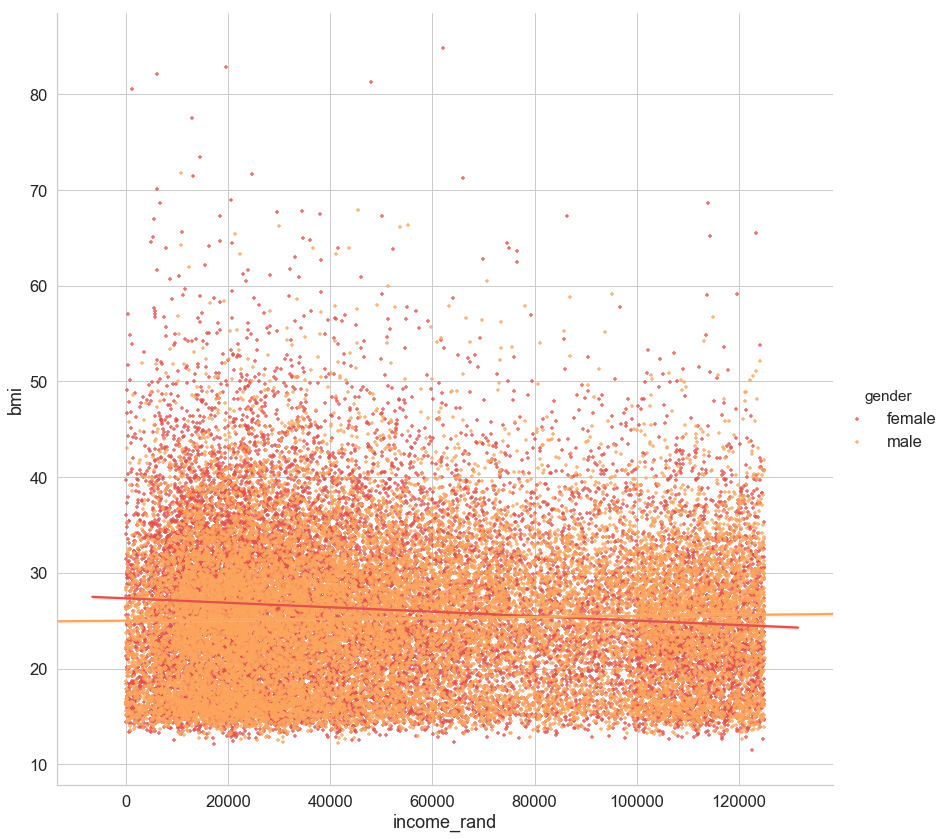

In [275]:
sns.set(style="whitegrid", palette='Spectral', color_codes=True, font_scale=1.5)
sns.lmplot(x='income_rand', y='bmi', hue='gender', data=df_bmi_income_p,
           size=12, markers='+', scatter_kws={"s": 10})

#### Auswertung Scatterplot und Box-Whisker-Plot
Der erstellte Scatterplot mit bietet schon einen Überblick über die Verteilung der Daten. Die Regressionslinien verlaufen um den mittleren BMI von 25 eher horizontal. Es scheint also auch hier wenig Korrelation zwischen BMI und Einkommen zu geben. Durch die Trennung der Datenpunkte nach Geschlecht ist jedoch zumindest bei den Frauen eine leichte Antikorrelation zu erahnen - die Linie fällt. Bei den Männer steigt die Kurve hingegen minimal an. Im Allgemeinen sind die Punkte aber für jede Einkommensklasse ähnlich (normal-)verteilt.  
Dies bestätigt auch eine Betrachtung des Box-Whisker-Plots, der zur Überprüfung auf eine Modifizierung der Einkommensdaten (Randomisierung innerhalb der Intervalle) verzichtet. Interessant ist dort die leichte Erhöhung des oberen "Whiskers" in den Einkommensklassen von 5.000-10.000 Dollar. Die Formen der krankhaften Fettleibigkeit scheinen in diesen unteren Einkommensklassen etwas häufiger aufzutreten.

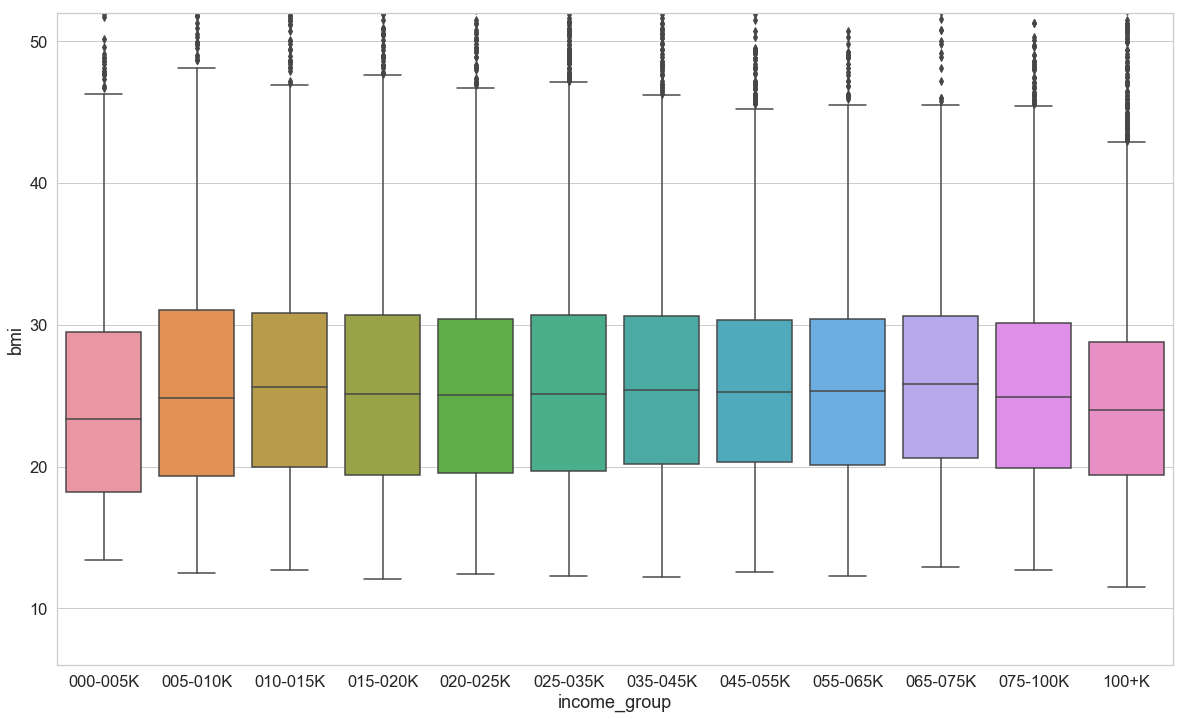

In [276]:
# Set plot style and scale.
sns.set(style="whitegrid", palette="pastel", color_codes=True, font_scale=1.5)
fig, ax = plt.subplots(figsize=(20,12))
ax.set_ylim(6, 52)
# Draw a box plot to compare the bmi distribution of the different income groups.
sns.boxplot(x='income_group', y='bmi', data=df_bmi_income_p, ax=ax,
           order=['000-005K','005-010K','010-015K','015-020K','020-025K','025-035K',
                 '035-045K','045-055K','055-065K','065-075K','075-100K','100+K'])

In [277]:
houshold_income = df_bmi_income_p['income_rand'].tolist()
bmi = df_bmi_income_p['bmi'].tolist()
bmi_income_slope, bmi_income_intercept, bmi_income_r_value, bmi_income_p_value, bmi_income_std_err = \
stats.linregress(houshold_income, bmi)
# Create a dataframe for nice packaging.
df_houshold_income_lingres = pd.DataFrame(index=['slope','intercept','r','r2','p','std_error'],
                                          columns=['values'])
df_houshold_income_lingres.at['slope','values'] = bmi_income_slope
df_houshold_income_lingres.at['intercept','values'] = bmi_income_intercept
df_houshold_income_lingres.at['r','values'] = bmi_income_r_value
df_houshold_income_lingres.at['r2','values'] = bmi_income_r_value**2
df_houshold_income_lingres.at['p','values'] = bmi_income_p_value
df_houshold_income_lingres.at['std_error','values'] = bmi_income_std_err
df_houshold_income_lingres

values
slope     -9.57863e-06
intercept      26.2167
r           -0.0437309
r2          0.00191239
p          2.71115e-18
std_error  1.09757e-06

#### Auswertung Lineare Regression und p-Test   
Alternativ zu Alpha-Fehler verwenden wir beim p-Test die Überschreitungswahrscheinlichkeit p. Diese wird im Rahmen der linearen Regression (Python SciPy-Bibliotheksfunktion) ermittelt. Der p-Wert für die lineare Korrelation von BMI und Einkommen ist mit 1.25e-19 erstaunlich niedrig und liegt deutlich unter der Grenze von 5%. Bei isolierter Betrachtung wäre also in Übereinstimmung mit dem Chi-Quadrat-Test die Nullthese abzulehnen. Es gibt demnach eine lineare Korrelation zwischen BMI und Einkommen. Gleichzeitig macht diese Aussage nach der visuellen Einschätzung der Daten intuitiv wenig Sinn. Der R-Quadrat-Wert ist mit 0.002 außerordentlich klein - gerade 0.2% der Abweichung wird somit durch das Regressionsmodell erklärt. Nehmen wir nun noch die Steigung der Regressionslinie hinzu, welche fast bei 0 liegt, dann muss festgestellt werden, dass eigentlich keine Aussage getroffen wurde.

><i>Die Nullhypothese kann nicht direkt durch den p-Wert verworfen werden. Die Alternativhypothese einer Antikorrelation von BMI und Einkommen ist aber auch nicht anzunehmen.</i>    

Dieser statistische Test kommt zu keiner entscheidenden Aussage. Der geringe p-Wert täuscht.

#### Auswertung Pearson-Korrelationskoeffizient
Zur abschließenden Betrachtung werden noch einige Korrelationskoeffizienten nach Bravais-Pearson ermittelt. Sie sind ein Maß für die Stärke des Zusammenhangs. die Berechnung erfolgt durch Division der Kovarianz der beiden betrachteten Variablen durch das Produkt ihrer Standardabweichungen.  

$$r = \frac{\sum_{i=1}^{n}(x_{i}-\bar{x})(y_{i}-\bar{y})}{\sqrt{\sum_{i=1}^{n}(x_{i}-\bar{x})^2}\sqrt{\sum_{i=1}^{n}(y_{i}-\bar{y})^2}}$$  

Für alle Stichproben zusammen liegt der Wert bei -4,48%. Werden nur die Frauen betrachtet, dann liegt der Wert bei -9.98%. Demnach bestätigt sich die im Scatterplot ausgemachte leichte Antikorrelation. In weiterer Übereinstimmung läuft der positive Wert von 2,32% dem Trend entgegen. Insgesamt muss festgestellt werden, dass aller Werte sehr dicht bei 0 liegen. Der Zusammenhang ist nachweislich äußerst schwach.

In [278]:
df_bmi_income_p[['bmi','income_rand']].corr('pearson')

bmi  income_rand
bmi          1.000000    -0.043731
income_rand -0.043731     1.000000

In [279]:
df_bmi_income_p_male = df_bmi_income_p[df_bmi_income_p['gender'] == 'male']
df_bmi_income_p_male[['bmi','income_rand']].corr('pearson')

bmi  income_rand
bmi          1.000000     0.024781
income_rand  0.024781     1.000000

In [280]:
df_bmi_income_p_female = df_bmi_income_p[df_bmi_income_p['gender'] == 'female']
df_bmi_income_p_female[['bmi','income_rand']].corr('pearson')

bmi  income_rand
bmi          1.000000    -0.099064
income_rand -0.099064     1.000000

### Fazit: BMI und Einkommensgruppe   
Für die Ausgangsthese der Untersuchung eines Zusammenhangs von BMI und Einkommen kann die These:

>Übergewicht und Fettleibigkeit korrelieren negativ mit Einkommen. Das heißt, mit sinkenden Einkommen steigt die Wahrscheinlichkeit für ungesundes Körpergewicht.  

nicht bestätigt werden. Auch wenn sowohl der Chi-Quadrat als auch der p-Test einen Zusammenhang nicht grundsätzlich ausschließen, zeigen weitere Untersuchungen doch offensichtlich, dass die Datenlage zu diffus ist, um eine Annahme der These zu rechtfertigen. Damit widerspricht diese Untersuchung der Mehrzahl der Studien, die Fettleibigkeit durch geringes Einkommen begünstigt sehen. Vermutlich müssen weitere sozioökonomische Faktoren hinzu gezogen, werden, um eine besseres Bild zu gewinnen. Dies soll im Folgenden in verkürzter Form durchgeführt werden.

### Präzisierung des Einkommens durch Mitglieder im Haushalt   
Wie bereits angedacht, muss das Haushaltseinkommen eventuell noch weiter präzisiert werden, indem die Anzahl der Mitglieder im jeweiligen Haushalt einbezogen werden. Die Vermutung wäre, dass Familien mit geringem noch zusätzlich benachteiligt werden, da vielleicht mehr Personen versorgt werden müssen. Tragen wir aber das berechnete Einkommen pro Kopf gegen den BMI in einem Scatterplot auf, so verändert sich der Eindruck nicht wesentlich. Die zuvor schon schwache Antikorrelation wird sogar noch weiter ausnivelliert.

(10, 60)

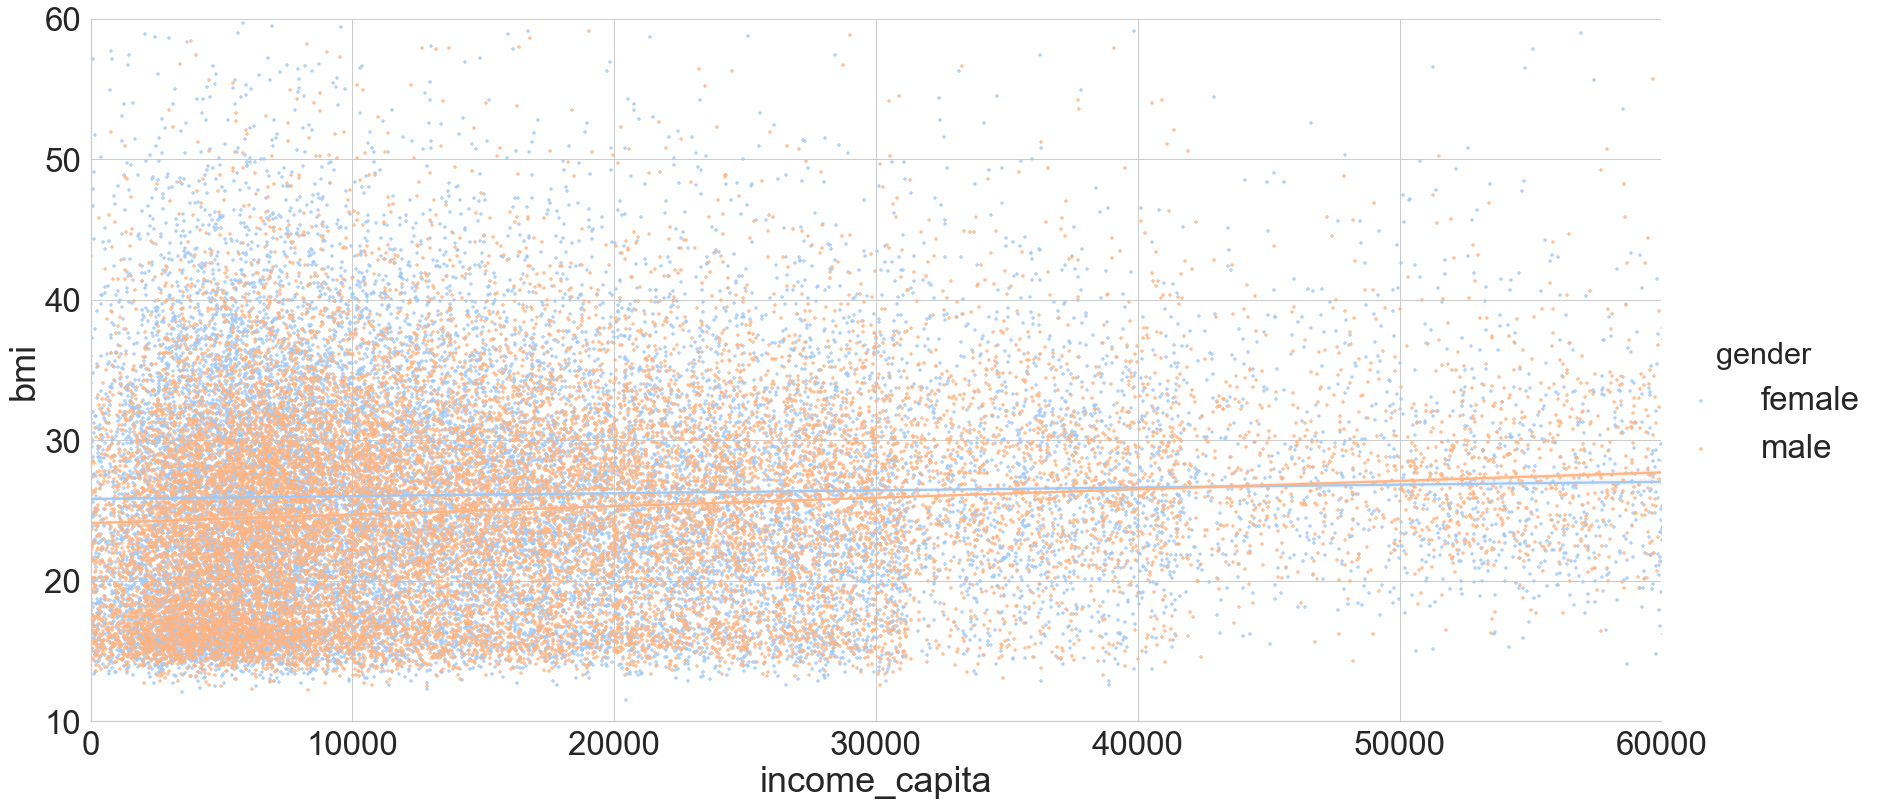

In [281]:
sns.set(style="whitegrid", palette='pastel', color_codes=True, font_scale=3)
lm = sns.lmplot(x='income_capita', y='bmi', hue='gender', data=df_bmi_income_p,
                markers='+', scatter_kws={"s": 10}, size=12, aspect=2)
ax = lm.axes
ax[0,0].set_xlim(0, 60000)
ax[0,0].set_ylim(10, 60)

#### Heatmap für Einkommen und Zahl der Haushaltsmitglieder   
Eine Untersuchung des Zusammenhangs von Einkommen und Mitgliederzahl mittels Heatmap, macht deutlich, dass gering verdienende Familien keineswegs mehr Personen (Großfamilien) zu versorgen haben. Stattdessen überwiegen in den unteren Einkommensklassen Ein- und Zweipersonenhaushalte, während vier Personen bei den Großverdienern Vorrang erhalten. Dies erklärt, warum die Mitgliederzahl im Haushalt, die Antikorrelation von BMI und Einkommen eher schwächt: Das Einkommen wird etwas angeglichen, wenn wir es auf die Köpfe der Familie verteilen. Dieser Faktor kann also in den weiteren Modellen vernachlässigt werden.

In [282]:
# Drop the columns we do not need here.
df_income_member_heat = df_bmi_income_p[['id','income_group','members']]
# Aggregate the count of observations for each income group and houshold member count.
df_income_member_heat = df_income_member_heat.groupby(['income_group','members']).count()
df_income_member_heat = df_income_member_heat.reset_index()
# Rename the id column as it is now the count of the samples.
df_income_member_heat.rename(columns={'id':'count'}, inplace=True)
# Transform the grouped table to spread out the variables along two axes (pivoting).
df_income_member_heat = df_income_member_heat.pivot(values='count',
                                                    index='members', columns='income_group')
# Calculate the total of each column.
df_income_member_heat = calculate_column_total(df_income_member_heat)
df_income_member_heat

income_group  000-005K  005-010K  010-015K  015-020K  020-025K  025-035K  \
members                                                                    
1                  292       603       817       545       457       624   
2                  145       264       571       605       571       928   
3                  210       305       469       455       697       832   
4                  159       266       397       496       613       976   
5                   92       196       357       376       535       903   
6                   77       133       155       305       364       508   
7                   88       111       180       236       307       411   
col_total         1063      1878      2946      3018      3544      5182   

income_group  035-045K  045-055K  055-065K  065-075K  075-100K  100+K  
members                                                                
1                  518       410       264       199       342    483  
2                  724       591       482       383       703   1149  
3                  537       514       441       332       627   1129  
4                  745       571       483       433       995   1920  
5                  633       554       402       347       609   1079  
6                  468       273       183       153       272    487  
7                  413       353       174       122       245    379  
col_total         4038      3266      2429      1969      3793   6626

In [283]:
# Now use the column total as a divider for each row to calculate percentages.
df_income_member_heat.index = df_income_member_heat.index.map(str)
df_income_member_heat = calculate_column_percentage_table(df_income_member_heat)
df_income_member_heat = df_income_member_heat.drop(['col_total'], axis=0)
df_income_member_heat

income_group  000-005K  005-010K  010-015K  015-020K  020-025K  025-035K  \
members                                                                    
1                0.275     0.321     0.277     0.181     0.129     0.120   
2                0.136     0.141     0.194     0.200     0.161     0.179   
3                0.198     0.162     0.159     0.151     0.197     0.161   
4                0.150     0.142     0.135     0.164     0.173     0.188   
5                0.087     0.104     0.121     0.125     0.151     0.174   
6                0.072     0.071     0.053     0.101     0.103     0.098   
7                0.083     0.059     0.061     0.078     0.087     0.079   

income_group  035-045K  045-055K  055-065K  065-075K  075-100K  100+K  
members                                                                
1                0.128     0.126     0.109     0.101     0.090  0.073  
2                0.179     0.181     0.198     0.195     0.185  0.173  
3                0.133     0.157     0.182     0.169     0.165  0.170  
4                0.184     0.175     0.199     0.220     0.262  0.290  
5                0.157     0.170     0.166     0.176     0.161  0.163  
6                0.116     0.084     0.075     0.078     0.072  0.073  
7                0.102     0.108     0.072     0.062     0.065  0.057

Text(0.5,1,'Income Group & Houshold Members')

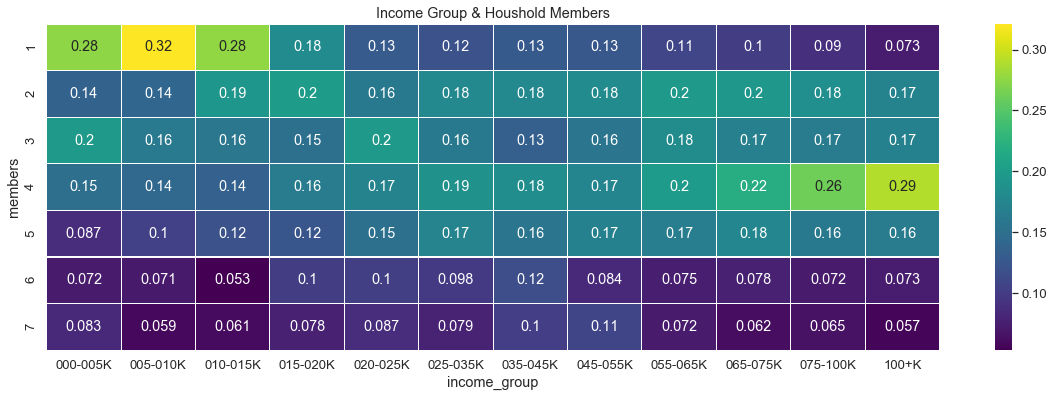

In [284]:
# Generate heatmap showing the number houshold members for each income group.
sns.set(font_scale=1.2)
fig, ax = plt.subplots(figsize=(20,6)) 
sns.heatmap(df_income_member_heat, ax=ax, cmap='viridis',
            linewidth=0.1, annot=True).set_title('Income Group & Houshold Members')

# <font color='#0099ff'>BMI</font><font color='grey'> und </font><font color='#0099ff'>Bildung</font>   
Ein gemeinhin mit dem Einkommen assoziierter sozioökonomischer Faktor ist die Bildung. Durch Einbezug dieses Feldes hoffen wir, die bisher diffusen Aussagen zu schärfen. In einem ersten Schritt soll geklärt werden, ob der NHANES-Datensatz die positive Korrelation von Bildung und Einkommensgruppe auch tatsächlich abbildet. Danach kann dann geprüft werden, welche Zusammenhänge zwischen Fettleibigkeit und Bildung bestehen.  
<b>Anmerkung:</b> Die Methodik der statistischen Nachweise mit Hypothesenpaar wurde bereits ausfühlich beleuchtet. In diesem Abschnitt wird auf diese Präzision weniger Wert gelegt, um einen breiteren Überblick zu gewinnen.

#### Selektion der Daten   
Für diese Untersuchung werden weiterhin die nutzen Daten zum BMI und Einkommen verwertet. Hinzu kommen Tabellenspalten zur Ausbildung der Referenzperson im Haushalt. Diese Information liegt in Form von Bildungskategorien vor, die als geordneter Code (Bildungslevel) eine Ordinalskala bilden.
<b>Bildungslevel:</b> {0_unknown; 1_<9th-Grade; 2_<12th-Grade; 3_Highschool; 4_AA-Degree; 5_College+}  
Schließlich ist auch das Geschlecht der Testpersonen für eine differenzierte Analyse relevant.

In [126]:
# Select education level and bmi columns from the categorized dataframe.
df_bmi_education = df_categ[['id','KG_M2_bmi','LAB_bmi', 'CAT_houshold_education',
                             'LAB_houshold_education','LAB_income_houshold','CAT_gender']] 
# Drop rows with missing values.
df_bmi_education = df_bmi_education.dropna()
# Rename the columns of the new dataframe for easier reding.
df_bmi_education.rename(columns={'KG_M2_bmi':'bmi',
                                 'LAB_bmi':'bmi_group',
                                 'CAT_houshold_education':'education_level',
                                 'LAB_houshold_education':'education',
                                 'LAB_income_houshold':'income',
                                 'CAT_gender':'gender'}, inplace=True)
# We also might want to use the semi-continuous income data we created earlier.
df_income_rand = df_bmi_income_p[['id','income_rand']]
df_bmi_education = df_bmi_education.merge(df_income_rand, how='inner', on='id')
df_bmi_education.head()

id    bmi bmi_group  education_level      education    income  gender  \
0  41475  58.04       40+                4    4_AA-Degree  025-035K  female   
1  41476  15.18     10-18                5     5_College+     100+K  female   
2  41477  30.05     30-35                3   3_Highschool  020-025K    male   
3  41479  27.56     25-30                1   1_<9th-Grade  045-055K    male   
4  41480  17.93     10-18                2  2_<12th-Grade  035-045K    male   

   income_rand  
0      31775.0  
1     106640.0  
2      22823.0  
3      53733.0  
4      41347.0

### Chi-Quadrat Test  für Einkommen und Bildung 

><b>Nullhypothese H0:</b> Einkommen und Bildung stochastisch unabhängig.  
<b>Alternativhypothese H1:</b> Einkommen und Bildung sind voneinander abhängige Variablen.   
<b>Sigma:</b> Gewählt wird ein Signifikanzniveau von 5% (p = 0.05).  

Der Chi-Quadrat-Test wird wiederum über die Kontingenztabelle mit den Merkmalen Bildungslevel und Einkommensklasse ermittelt. Der berechnete Wert ist 10.133. Bei vorhandenen 44 Freiheitsgraden würde die Wahrscheinlichkeit, dass Chi-Quadrat einen Wert von 60,46 erreicht bei 5% liegen. Dies ist das gewählte Signifikanzniveau. Da der berechnete Wert weit darüber liegt, ist die Nullhypothese zu verwerfen.

><i>Bildung und Einkommen sind stochastisch abhängig.</i>   

In [115]:
# Drop the values which do not fit in the same categorization class and would distort the calculation.
df_bmi_education_redux = df_bmi_education[(df_bmi_education['income'] != '<020K') & \
                                          (df_bmi_education['income'] != '>020K') & \
                                          (df_bmi_education['income'] != 'unknown') & \
                                          (df_bmi_education['education'] != '0_unknown')]
# Easier way to create the needed contingency (cross)table (via library function).
df_education_income_crosstable_total = pd.crosstab(df_bmi_education_redux['education'],
                                                   df_bmi_education_redux['income'],
                                                   margins=True)
df_education_income_crosstable_total

income         000-005K  005-010K  010-015K  015-020K  020-025K  025-035K  \
education                                                                   
1_<9th-Grade        170       380       509       552       572       650   
2_<12th-Grade       281       512       732       628       773      1014   
3_Highschool        270       440       750       817       930      1347   
4_AA-Degree         246       403       729       758       918      1516   
5_College+           76        94       167       207       284       563   
All                1043      1829      2887      2962      3477      5090   

income         035-045K  045-055K  055-065K  065-075K  075-100K  100+K    All  
education                                                                      
1_<9th-Grade        453       309       118        76        98     79   3966  
2_<12th-Grade       571       399       280       224       266    199   5879  
3_Highschool       1045       845       547       407       671    705   8774  
4_AA-Degree        1274      1013       878       660      1300   1537  11232  
5_College+          616       598       548       556      1328   3889   8926  
All                3959      3164      2371      1923      3663   6409  38777

In [116]:
# Calculate the expected values for the contingency table.
df_education_income_crosstable_expect = calculate_crosstable_expected(df_education_income_crosstable_total)
df_education_income_crosstable_expect

income         000-005K  005-010K  010-015K  015-020K  020-025K  025-035K  \
education                                                                   
1_<9th-Grade     106.68    187.06    295.27    302.94    355.62    520.59   
2_<12th-Grade    158.13    277.30    437.70    449.07    527.15    771.70   
3_Highschool     236.00    413.84    653.24    670.21    786.73   1151.70   
4_AA-Degree      302.11    529.78    836.24    857.96   1007.13   1474.35   
5_College+       240.09    421.01    664.55    681.82    800.36   1171.66   
All             1043.00   1829.00   2887.00   2962.00   3477.00   5090.00   

income         035-045K  045-055K  055-065K  065-075K  075-100K    100+K  \
education                                                                  
1_<9th-Grade     404.92    323.60    242.50    196.68    374.64   655.49   
2_<12th-Grade    600.23    479.70    359.47    291.55    555.35   971.67   
3_Highschool     895.80    715.91    536.48    435.11    828.82  1450.15   
4_AA-Degree     1146.75    916.47    686.77    557.01   1061.01  1856.41   
5_College+       911.31    728.31    545.78    442.65    843.18  1475.27   
All             3959.00   3164.00   2371.00   1923.00   3663.00  6409.00   

income             All  
education               
1_<9th-Grade    3966.0  
2_<12th-Grade   5879.0  
3_Highschool    8774.0  
4_AA-Degree    11232.0  
5_College+      8926.0  
All            38777.0

In [98]:
# Calculate the discrepency between real and expected values.
df_education_income_crosstable_diff = calculate_crosstable_difference(df_education_income_crosstable_total,
                                                                      df_education_income_crosstable_expect)
df_education_income_crosstable_diff

income         000-005K  005-010K  010-015K  015-020K  020-025K  025-035K  \
education                                                                   
1_<9th-Grade      63.32    192.94    213.73    249.06    216.38    129.41   
2_<12th-Grade    122.87    234.70    294.30    178.93    245.85    242.30   
3_Highschool      34.00     26.16     96.76    146.79    143.27    195.30   
4_AA-Degree      -56.11   -126.78   -107.24    -99.96    -89.13     41.65   
5_College+      -164.09   -327.01   -497.55   -474.82   -516.36   -608.66   

income         035-045K  045-055K  055-065K  065-075K  075-100K    100+K  
education                                                                 
1_<9th-Grade      48.08    -14.60   -124.50   -120.68   -276.64  -576.49  
2_<12th-Grade    -29.23    -80.70    -79.47    -67.55   -289.35  -772.67  
3_Highschool     149.20    129.09     10.52    -28.11   -157.82  -745.15  
4_AA-Degree      127.25     96.53    191.23    102.99    238.99  -319.41  
5_College+      -295.31   -130.31      2.22    113.35    484.82  2413.73

In [99]:
# Calculate Chi2 for education and houshold income.
chi2_education_income = calculate_crosstable_chi2(df_education_income_crosstable_diff,
                                                  df_education_income_crosstable_expect)
chi2_education_income

10133.495914717023

In [103]:
df_education_income_chi2 = calculate_crosstable_contingency_pearson(df_education_income_crosstable_total,
                                                                    chi2_education_income, sigma=0.05)
df_education_income_chi2

values
Chi2               10133.5
C_norm            0.455175
C_max             0.894427
C_corr            0.508901
n_samples            38777
k_min                    5
degree_free             44
sigma                 0.05
Chi2_significant   60.4809

### Korrelationkoeffizient und Boxplot   
Über den Kontingenzkoeffizienten (Bravais-Pearson) lässt sich für Einkommen und Bildung klar eine positive Korrelation nachweisen. Der entsprechende Wert liegt bei 39,83% Prozent. Dieser Zusammenhang ist auch im Boxplot abzulesen: Das mittlere Einkommen steigt streng monoton mit dem Bildungslevel und auch die Quartile liegen durchweg höher. Der Anstieg scheint nicht linear sondern quadratisch bis exponentiell zu erfolgen. Da es sich bei den Bildungsleveln aber nicht um Werte auf einer Intervallskala handelt, ist die Herstellung einer echten mathematischen Funktion jedoch nicht möglich. Die Tendenz bleibt immerhin zu erkennen, ebenso wie die Aufspreizung der Einkommensverteilung in den höheren Bildungsklassen. Die ohne Bildunglevel erfassten Haushaltseinkommen (fehlende Daten) verteilen sich recht gut normal um den Mittelwert aller anderen Einkommen. Wir erwarten daher wenig statistische Verzerrung bei Ausschluss dieser Stichproben, die Zudem nur einen Anteil von 3,24% umfassen (siehe Kategorisierung der NHANES-Daten).

In [128]:
df_bmi_education[['education_level','income_rand']].corr('pearson')

education_level  income_rand
education_level         1.000000     0.398343
income_rand             0.398343     1.000000

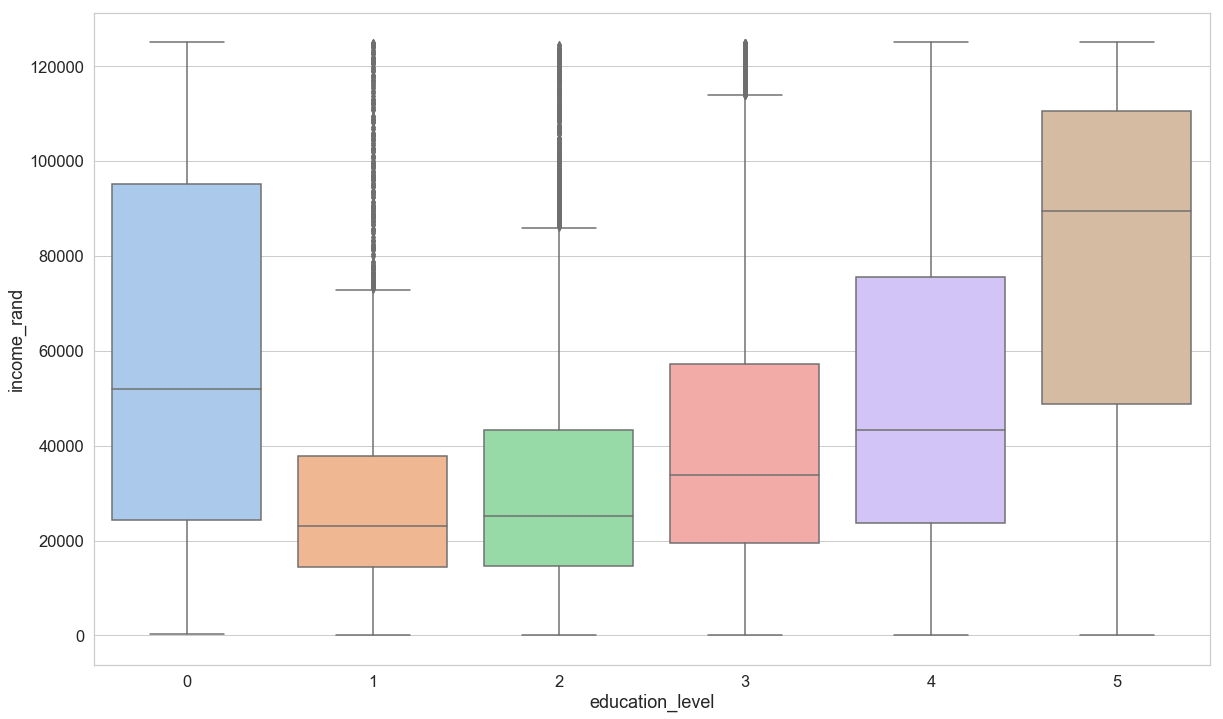

In [220]:
# Set plot style and scale.
sns.set(style="whitegrid", palette="pastel", color_codes=True, font_scale=1.5)
fig, ax = plt.subplots(figsize=(20,12))
# Draw a box plot to compare the income distribution of the different education levels.
sns.boxplot(x='education_level', y='income_rand', data=df_bmi_education, ax=ax)

#### Heatmap für Einkommen und Bildungslevel   
Eine alternative Darstellung, die die positive Korrelation von Bildung und Einkommen offen legt, ist die "Heatmap". Diese kann aus der zuvor erstellten Kontingenztabelle abgeleitet werden. Die relativen Häufiglkeiten in Bezug auf die Einkommensgruppe (Division durch Spaltensumme) sind zu berechnen. Somit Zeigt die "Heatmap" für jede Einkommensgruppe prozentual, aus welchen Bildungsklassen sich die Testpersonen speisen. Das diagonale Hitzeband bestätigt die Ergebnisse.

In [121]:
# Drop the columns we do not need here.
df_education_income_stats = df_bmi_education.drop(['bmi','gender','education_level','income_rand'],
                                                  axis=1).copy()
# Aggregate the count of observations for each income group and education level.
df_education_income_stats = df_education_income_stats.groupby(['education','income']).count()
df_education_income_stats = df_education_income_stats.reset_index()
# Rename the id column as it is now the count of the samples.
df_education_income_stats.rename(columns={'id':'count'}, inplace=True)
# Transform the grouped table to spread out the variables along two axes (pivoting).
df_education_income_stats = df_education_income_stats.pivot(values='count',
                                                            index='education',
                                                            columns='income')
# Drop ambiguous data fields such as unknown income or education group.
df_education_income_stats = df_education_income_stats.drop(['0_unknown'], axis=0)
# Calculate the total of each row and column.
df_education_income_stats = calculate_column_total(df_education_income_stats)
df_education_income_stats = calculate_row_total(df_education_income_stats)
df_education_income_stats

income         000-005K  005-010K  010-015K  015-020K  020-025K  025-035K  \
education                                                                   
1_<9th-Grade        170       380       509       552       572       650   
2_<12th-Grade       281       512       732       628       773      1014   
3_Highschool        270       440       750       817       930      1347   
4_AA-Degree         246       403       729       758       918      1516   
5_College+           76        94       167       207       284       563   
col_total          1043      1829      2887      2962      3477      5090   

income         035-045K  045-055K  055-065K  065-075K  075-100K  100+K  \
education                                                                
1_<9th-Grade        453       309       118        76        98     79   
2_<12th-Grade       571       399       280       224       266    199   
3_Highschool       1045       845       547       407       671    705   
4_AA-Degree        1274      1013       878       660      1300   1537   
5_College+          616       598       548       556      1328   3889   
col_total          3959      3164      2371      1923      3663   6409   

income         row_total  
education                 
1_<9th-Grade        3966  
2_<12th-Grade       5879  
3_Highschool        8774  
4_AA-Degree        11232  
5_College+          8926  
col_total          38777

In [122]:
# Now use the column total as a divider for each row to calculate percentages.
df_education_income_percent = calculate_column_percentage_table(df_education_income_stats)
df_education_income_percent = df_education_income_percent.drop(['row_total'], axis=1)
df_education_income_percent

income         000-005K  005-010K  010-015K  015-020K  020-025K  025-035K  \
education                                                                   
1_<9th-Grade      0.163     0.208     0.176     0.186     0.165     0.128   
2_<12th-Grade     0.269     0.280     0.254     0.212     0.222     0.199   
3_Highschool      0.259     0.241     0.260     0.276     0.267     0.265   
4_AA-Degree       0.236     0.220     0.253     0.256     0.264     0.298   
5_College+        0.073     0.051     0.058     0.070     0.082     0.111   
col_total         1.000     1.000     1.000     1.000     1.000     1.000   

income         035-045K  045-055K  055-065K  065-075K  075-100K  100+K  
education                                                               
1_<9th-Grade      0.114     0.098     0.050     0.040     0.027  0.012  
2_<12th-Grade     0.144     0.126     0.118     0.116     0.073  0.031  
3_Highschool      0.264     0.267     0.231     0.212     0.183  0.110  
4_AA-Degree       0.322     0.320     0.370     0.343     0.355  0.240  
5_College+        0.156     0.189     0.231     0.289     0.363  0.607  
col_total         1.000     1.000     1.000     1.000     1.000  1.000

Text(0.5,1,'Income Group & Houshold Income')

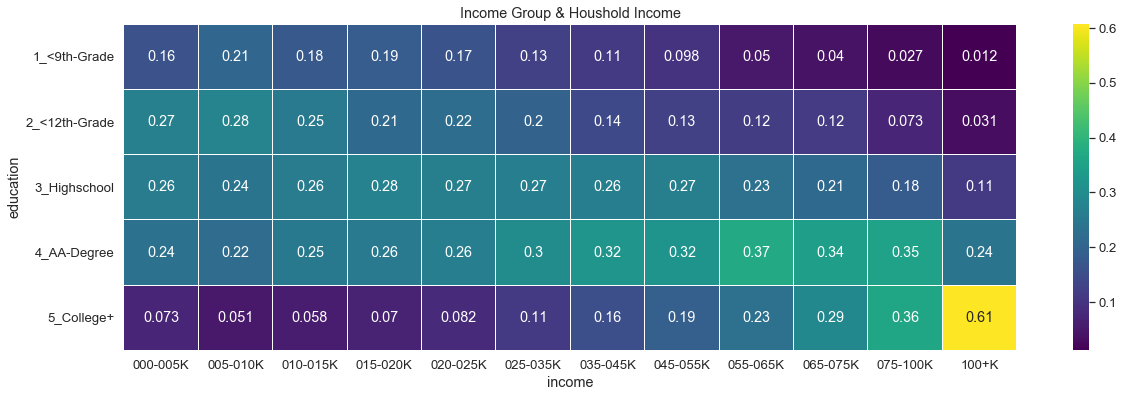

In [123]:
# Drop the total data fields.
df_education_income_heat = df_education_income_percent.drop(['col_total'], axis=0)
# Generate heatmap showing the income distribution among the different education levels.
sns.set(font_scale=1.2)
fig, ax = plt.subplots(figsize=(20,6)) 
sns.heatmap(df_education_income_heat, ax=ax, cmap='viridis',
            linewidth=0.1, annot=True).set_title('Income Group & Houshold Income')

### BMI Verteilung nach Bildungslevel   
Da nun der triviale Zusammenhang zwischen Bildung und Einkommen nachgewiesen wurde, ist zumindest klar gestellt, dass die NHANES-Daten überhaupt eine Aussagekraft besitzen. Um so mehr ist demnach auch den der Intuition entgegen laufenden Erkenntnissen zu trauen.  
In diesem Schritt wird nun die Beziehung zwischen Bildungslevel und BMI beleuchtet. Als Hypothese anzunehmen wäre eine negative Korrelation zwischen diesen Variablen. Bei einem höheren Bildungslevel müsste demnach der Anteil and Übergewichtigen und Fettleibigen deutlich sinken. 

#### Violinplot der BMI-Verteilung nach Bildungslevel  
äUm der Vermutung nachzugehen kann ein Violinplot genutzt werden. Dieser stellt die Dichtefunktion des BMI für jedes Bildungslevel dar. Für zusätzlichen Informationsgewinn wird zudem nach Geschlecht differenziert. Auch hier zeigt sich ein Bild, dass der zuvor erfolgten Gegenüberstellung von BMI und Einkommen entspricht: Der BMI liegt bei den Frauen zunächst etwas höher. Über die ersten vier Bildunglevel liegen die Median- und Quartilslinien in etwa auf gleicher Höhe. Dies würde implizieren, dass das Problem von Übergewicht und Fettleibigkeit als Breitenphänomen vollkommen losgelöst vom Bildungsstand ist. Das Bildungslevel 5 (College und Universität) weist jedoch einen starken Rückgang in den höheren BMI-Klassen auf. Insbesondere bei den Frauen liegen die Kennlinien dort deutlich niedriger und erstmals sogar unter den Werten der männlichen Testpersonen. Wie schon beim Einkommen gilt für Frauen eine negative Korrelation von Bildung und BMI, die allerdings erst auf dem höchsten Level signifikant greift. Bei den Männern ist diese Tendenz weniger stark ausgeprägt. Der Rückgang betrifft vor allem die Bereiche krankhafter Fettleibigkeit (oberes Quartil).

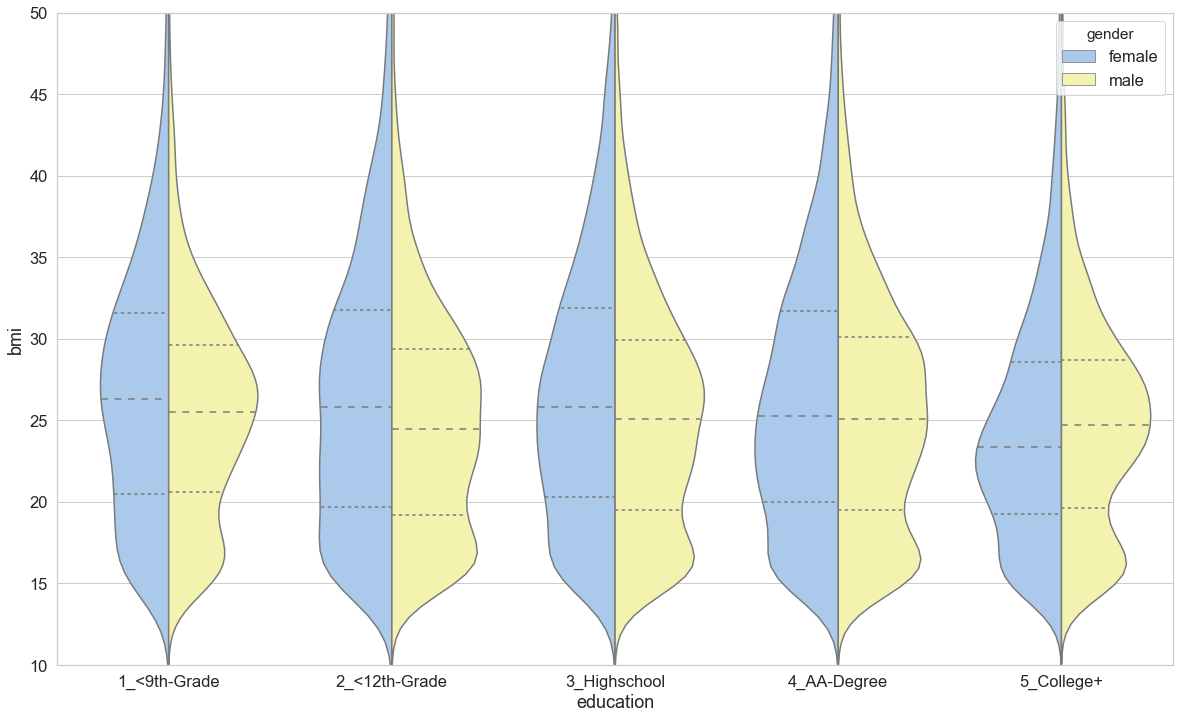

In [140]:
# Set plot style and scale.
sns.set(style="whitegrid", palette="pastel", color_codes=True, font_scale=1.5)
fig, ax = plt.subplots(figsize=(20,12))
ax.set_ylim(10, 50)
# Draw a nested violinplot and split the violins for easier gender comparison.
sns.violinplot(x='education', y='bmi', hue='gender', data=df_bmi_education,
               split=True, inner='quart', palette={'male':'y','female':'b'}, ax=ax,
               order=['1_<9th-Grade','2_<12th-Grade','3_Highschool','4_AA-Degree','5_College+'])

#### Korrelationkoeffizient für BMI und Bildungslevel   
Der Korrelationskoeffizient für BMI und Bildung (nach Bravais-Pearson) liegt bei -4,9% und bestätigt somit die aus den Violinplots abgelesene leichte Antikorrelation. Gerade im Vergleich zu den bei der Verknüpfung von Einkommen und Bildung erreichten 39,9% wir deutlich, wie dünn der Hinweis auf eine lineare Beziehung ist. Die Spur einer Korrelation speist sich vor allem aus dem deutlichen Abfall des starken Übergewichts im höchsten Bildungslevel bei gleichzeitig ausbleibender Gegentendenz in allen anderen Stufen.

In [142]:
df_bmi_education_redux[['education_level','bmi']].corr('pearson')

education_level       bmi
education_level         1.000000 -0.049918
bmi                    -0.049918  1.000000

#### Median von BMI-Verteilung nach Bildungslevel  

In [136]:
# Drop the columns we do not need here.
df_bmi_education_median = df_bmi_education.drop(['id','income'], axis=1).copy()
# Aggregate the median bmi for each education level (separated by gender).
df_bmi_education_median = df_bmi_education.groupby(['gender','education']).median()
df_bmi_education_median = df_bmi_education_median.reset_index()
# Pivot the table to spread the variables on two axes.
df_bmi_education_median = df_bmi_education_median.pivot(values='bmi',
                                                        index='gender',
                                                        columns='education')
df_bmi_education_median

education  0_unknown  1_<9th-Grade  2_<12th-Grade  3_Highschool  4_AA-Degree  \
gender                                                                         
female         24.12         26.32          25.80         25.80         25.3   
male           23.54         25.50          24.45         25.09         25.1   

education  5_College+  
gender                 
female          23.39  
male            24.70

# <font color='#0099ff'>BMI</font><font color='grey'> und </font><font color='#0099ff'>Ethnische Gruppierung</font>   
Für das Einwanderungsland USA stellt die Zugehörigkeit zu einer ethnischen Gruppierung einen vielleicht entscheidenden sozioökonomischen Faktor dar. Daher soll dieser hier nicht vernachlässigt werden. Wenn die Tendenz zu Übergewicht und Fettleibigkeit in einigen dieser Bevölkerungsanteile auffällig aus dem Mittel fällt, dann ist weiterhin zu untersuchen, welchen Bildungszugang diese Gruppe hat und ob sich eventuell dementsprechend auch die Einkommensverteilung unterscheidet.

#### Selektion der Daten   
Für die Betrachtung der der ethnischen Zugehörigkeit stehen im NHANES-Datensatz vier Klassen zur Verfügung.  
<b>Ethnie:</b> {white; black; mexican; hispanic; other}   
Die Unterscheidung zwischen Mexicans und Lateinamerikanern anderer Regionen scheint zunächst etwas sonderbar. Da beide Gruppen aber mit einem umfassenden Datenkörper vertreten sind und in den USA durchaus in einem anderen sozialen Kontext stehen, macht eine solche Teilung Sinn. Etwas problematisch ist hingegen die Gruppe "other". Sie umfasst viele marginale Minderheiten, sowie auch die größere Gruppe der Asiaten. Eine weitere Differenzierung wäre hier wünschenswert, wurde im Rahmen des NHANES-Programms aber erst in den letzten drei der insgesamt fünf verwendeten Jahrgänge vorgenommen. Daher musste mit Rücksicht auf die Homogenität der Daten eine Anpassung auf das gröbere Level hingenommen werden. Immerhin sind so alle definierten Merkmalsausprägungen mit einem repräsentativen Anteil and der Grundgesamtheit vertreten. Fehlende Daten gibt es nicht.

In [172]:
# Select the bmi, race and houshold income columns from the categorized data table.
df_bmi_income_race = df_categ[['id','KG_M2_bmi','LAB_bmi','CAT2_race','LAB_income_houshold','CAT_gender']].copy()
# Drop missing values as our sample size is still representative and large.
df_bmi_income_race = df_bmi_income_race.dropna()
# Rename the columns of the new dataframe for easier reding.
df_bmi_income_race.rename(columns={'KG_M2_bmi':'bmi',
                                   'LAB_bmi':'bmi_group',
                                   'CAT2_race':'race',
                                   'CAT_gender':'gender',
                                   'LAB_income_houshold':'houshold_income'}, inplace=True)

In [166]:
# Get an overview over the number of samples in each ethnic group.
df_race_stats = df_bmi_income_race[['id','race']].groupby('race').count()
df_race_stats = df_race_stats.reset_index()
df_race_stats.rename(columns={'id':'count'}, inplace=True)
df_race_stats.transpose()

0         1        2      3      4
race   black  hispanic  mexican  other  white
count   9932      4871     8007   5123  15979

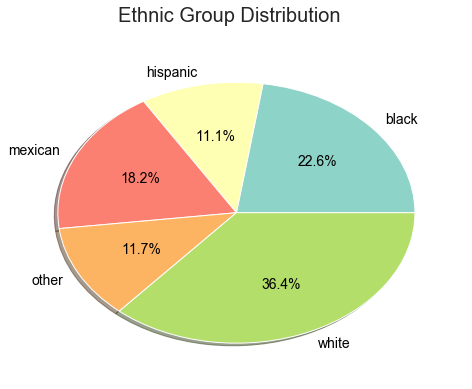

In [167]:
# Plot the sammple count as a relative percentage pie chart.
plot_pie_chart_2('Ethnic Group Distribution', df_race_stats, 'race', 'count', (8,6), 'Set3')

#### BMI Verteilung in Ethnischen Gruppen via Box-Whisker-Plot   
Ein Box-Whisker-Plot, welcher die Verteilung des BMI in den verschiedenen ethnischen Gruppen darstellt, ist durchaus aufschlussreich: Die Tendenz zu einem erhöhten BMI ist bei Afroamerikanern und mexikanischen Einwanderern deutlich ausgeprägter. Insbesondere bei den Afroamerikanern gibt es eine markante Verschiebung des oberen Quartils hinein in den Bereich der krankhaften Fettleibigkeit (BMI über 30). In dieser Gruppierung erreicht der obere Whisker auch den sehr bedenklichen BMI-Wert von 50. Obwohl also die Medianwerte bei vier der fünf ethnischen Gruppen gleichauf im leichten Übergewicht bei 26 liegen, gibt es bei Afroamerikanern und auch Mexikanern einen entschieden größeren Anteil an gesundheitlich kritischer Fettleibigkeit.   
Das ganze Gegenteil findet sich in der Sammelgruppe "other". Hier liegt der Median im Normalgewicht und das obere Quartil rückt runter in das leichte Übergewicht. Dies ist vermutlich stark bedingt durch den Anteil an Asiaten in dieser Gruppe, was in einer Nebenuntersuchung kurz geprüft wurde (hier aber nicht dargestellt werden soll).

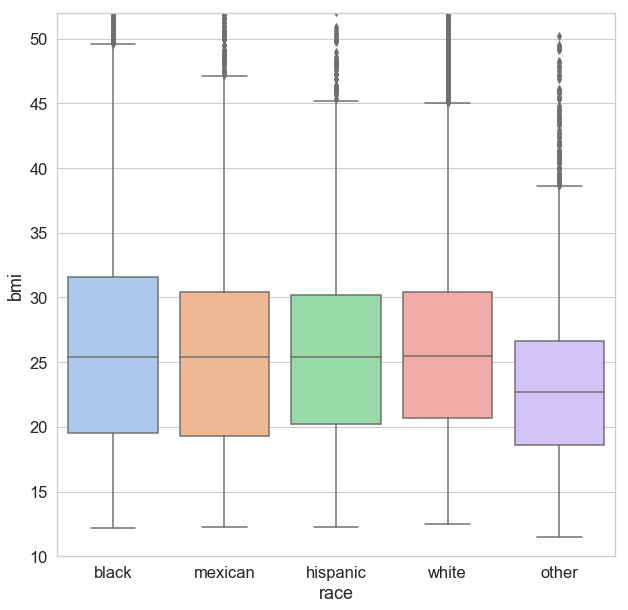

In [177]:
# Set plot style and scale.
sns.set(style="whitegrid", palette="pastel", color_codes=True, font_scale=1.5)
fig, ax = plt.subplots(figsize=(10,10))
ax.set_ylim(10, 52)
# Draw a box plot to compare the bmi distribution of the different ethnic groups.
sns.boxplot(x='race', y='bmi', data=df_bmi_income_race, ax=ax,
            order=['black','mexican','hispanic','white','other'])

#### BMI Verteilung in Ethnischen Gruppen - weitere Differenzierung nach Geschlecht
Eine weiter Differenzierung nach Geschlecht wird Mittels eines geteilten Violinplots möglich. Hier überrascht die Rolle der weiblichen Testpersonen innerhalb der afroamerikanischen Gruppe. Während sich die Verteilung des BMI der männlichen Teilnehmer der Studie nicht allzu stark von Weißen, Mexikanern und Lateinamerikanern unterscheidet, wird der zuvor ausgemachte BMI-Anstieg in den krankhaften Bereich vor allem durch Frauen realisiert. Die obere Quartilsline nähert sich stark einem BMI, der einer Adipositas Grad II entspricht. In der ethnischen Sammelgruppe "other" kehrt sich diese Struktur hingegen um.

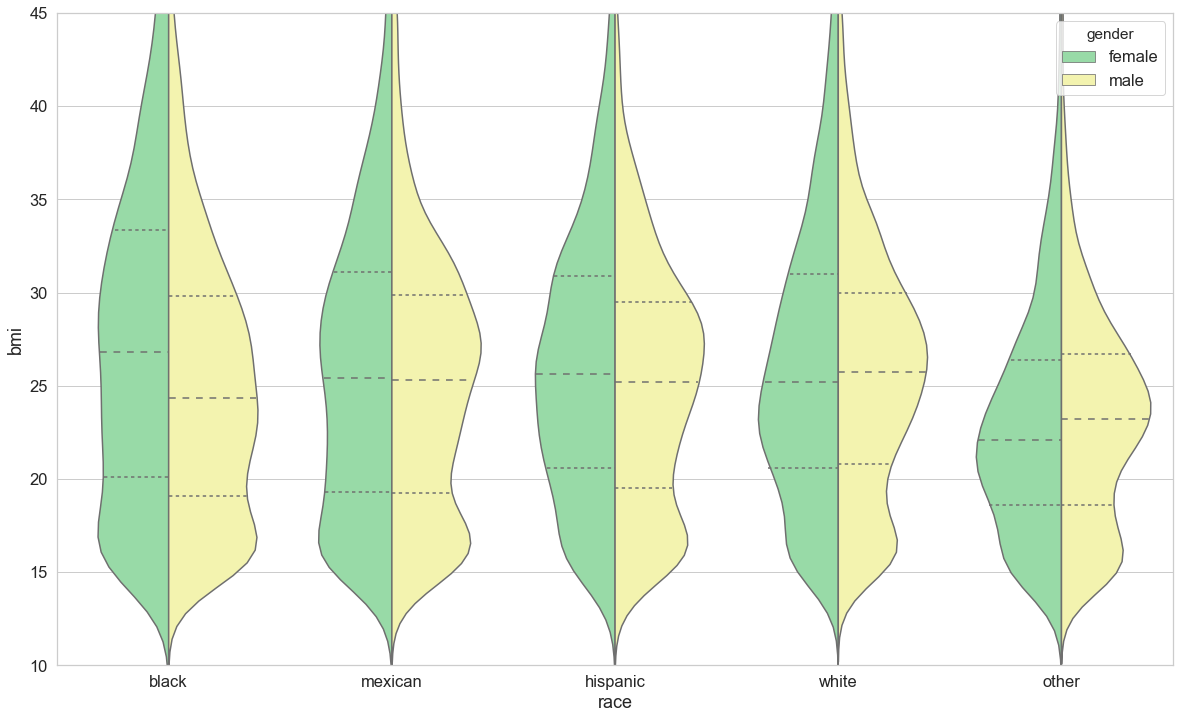

In [180]:
# Set plot style and scale.
sns.set(style="whitegrid", palette="pastel", color_codes=True, font_scale=1.5)
fig, ax = plt.subplots(figsize=(20,12))
ax.set_ylim(10, 45)
# Draw a nested violinplot and split the violins for easier gender comparison.
sns.violinplot(x='race', y='bmi', hue='gender', data=df_bmi_income_race,
               split=True, inner='quart', palette={'male':'y','female':'g'}, ax=ax,
               order=['black','mexican','hispanic','white','other'])

#### Prozentualer Anteil von Adipositas (nur Frauen)   
Da der Anteil an Frauen mit Adipositas I-III in der ethnischen Gruppe der Afroamerikaner so markant ausfällt, stellen wir diesen Aspekt noch einmal als gestapeltes Balkendiagramm dar. Hier werden für alle Ethnien nur die Frauen in den vier erhöhten BMI Klassen erfasst. Deutlich ist zu erkennen, dass mit Ausnahme der "others"-Gruppe der Gesamtanteil von Übergewichtigen (mit 52%) in etwa gleich groß ist. Bei den afroamerikanischen Frauen findet jedoch eine innerhalb des Übergewichts eine starke Verschiebung in den krankhaften Bereich (Adipositas I-III) statt.

In [216]:
# For the bmi group counting we fo not need the exact bmi.
df_bmi_race_stats = df_bmi_income_race[(df_bmi_income_race['gender'] == 'female')]
df_bmi_race_stats = df_bmi_race_stats.drop('bmi', axis=1).copy()
# Aggregate the count of observations for each ethnic group and bmi class.
df_bmi_race_stats = df_bmi_race_stats.groupby(['race','bmi_group']).count()
df_bmi_race_stats = df_bmi_race_stats.reset_index()
# Rename the columns of the new dataframe for easier reding.
df_bmi_race_stats.rename(columns={'id':'count','bmi_group':'bmi'}, inplace=True)
# Transform the grouped table to spread out the variables along two axes (pivoting).
df_bmi_race_stats = df_bmi_race_stats.pivot(values='count', index='bmi', columns='race')
# Calculate the total of each new colum.
df_bmi_race_stats = calculate_column_total(df_bmi_race_stats)
df_bmi_race_stats = calculate_row_total(df_bmi_race_stats)
df_bmi_race_stats

race       black  hispanic  mexican  other  white  row_total
bmi                                                         
10-18        981       419      887    624   1289       4200
18-25       1200       778     1065   1136   2572       6751
25-30        981       624      924    451   1806       4786
30-35        857       437      640    220   1127       3281
35-40        496       193      345     81    627       1742
40+          512       124      216     51    492       1395
col_total   5027      2575     4077   2563   7913      22155

In [207]:
df_bmi_race_percent = calculate_column_percentage_table(df_bmi_race_stats).drop('row_total', axis=1)
df_bmi_race_percent

race       black  hispanic  mexican  other  white
bmi                                              
10-18      0.211     0.187    0.222  0.243  0.169
18-25      0.270     0.288    0.258  0.421  0.301
25-30      0.210     0.264    0.250  0.210  0.262
30-35      0.156     0.160    0.159  0.083  0.151
35-40      0.079     0.065    0.067  0.027  0.069
40+        0.075     0.037    0.043  0.017  0.048
col_total  1.000     1.000    1.000  1.000  1.000

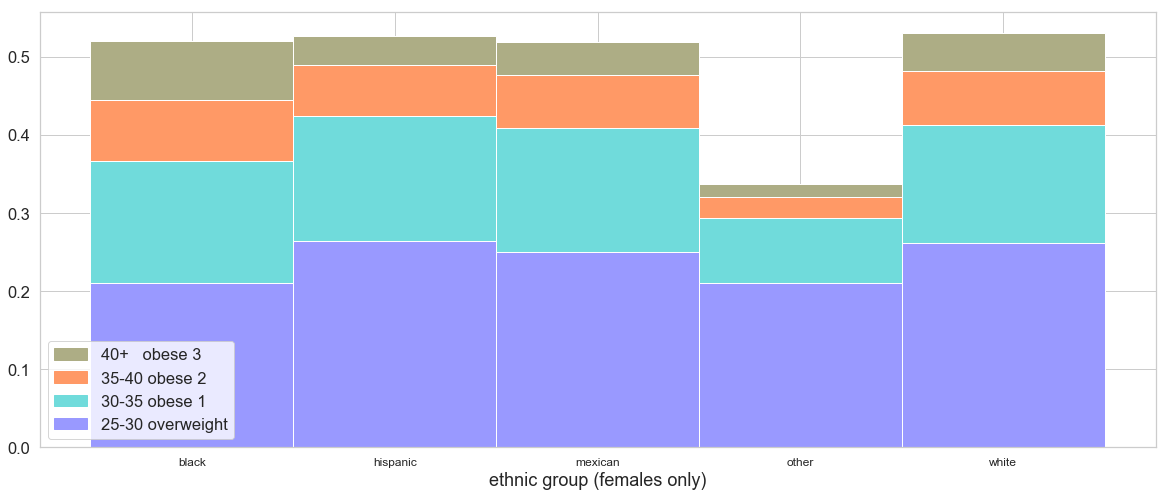

In [209]:
plot_obesity_barstack('ethnic group ()', df_bmi_race_percent)

#### Heatmap des Median BMI nach Einkommon und ethnischer Gruppe    
Betrachtung des BMI in Hinblick auf die ethnische Gruppe, kann zusätzlich nach Einkommen differenziert werden. Dies wird durch die Bildung einer Heatmap ermöglicht, die den median des BMI für jede Ethnie und Einkommensklasse kartiert. Dies verschafft nur einen ersten Überblick, da die dargestellten Werte noch keine präzise Aussage über den eigentlichen Anteil an Übergewichtigen machen. Ein erhöhter median weist jedoch auch auf größere Anteile in den oberen BMI-Klassen hin. Interessant sind hier vor allem zwei Beobachtungen: Sowohl bei den Mexikanern als auch bei den Afroamerikanern liegen die Spitzen in den oberen Einkommensklassen. Die Antikorrelation von BMI und Haushaltseinkommen gilt hier gerade nicht. Nur bei den weißen Amerikanern gibt es einen minimalen Schwerpunkt in einem Intervall von 10-15 Tausend Dollar. Da der Anteil der weißen Bevölkerung aber in den USA mit 36,1% überwiegt, nivellieren sich die widersprüchlichen Tendenzen aus.

In [39]:
# Aggregate the median bmi for each income level (separated by ethnic group).
df_bmi_income_race_median = df_bmi_income_race.groupby(['race','houshold_income']).median()
df_bmi_income_race_median = df_bmi_income_race_median.reset_index()
# Pivot the table to spread the variables on two axes.
df_bmi_income_race_median = df_bmi_income_race_median.pivot(values='bmi',
                                                            index='race',
                                                            columns='houshold_income')
df_bmi_income_race_median.head()

houshold_income  000-005K  005-010K  010-015K  015-020K  020-025K  025-035K  \
race                                                                          
black              22.685     24.20    24.515    24.565    24.400    25.000   
hispanic           23.200     25.46    25.600    26.100    25.235    25.925   
mexican            25.100     24.60    25.420    24.200    25.110    25.100   
other              21.400     23.85    23.340    23.700    23.200    22.500   
white              25.050     25.95    26.715    26.305    25.760    25.720   

houshold_income  035-045K  045-055K  055-065K  065-075K  075-100K   100+K  \
race                                                                        
black              25.600     26.10    26.600    26.250    26.600  26.850   
hispanic           25.785     25.20    25.350    26.090    24.830  24.120   
mexican            26.135     25.35    25.755    27.025    25.400  24.615   
other              23.000     23.20    23.360    22.900    22.300  22.000   
white              25.900     25.57    25.500    26.100    25.365  24.300   

houshold_income   <020K   >020K  unknown  
race                                      
black            21.900  27.750   25.900  
hispanic         25.310  26.300   25.400  
mexican          23.900  26.925   25.700  
other            21.800  22.900   22.820  
white            28.245  25.800   25.295

Text(0.5,1,'Median BMI related to Ethnical Groups & Houshold Income')

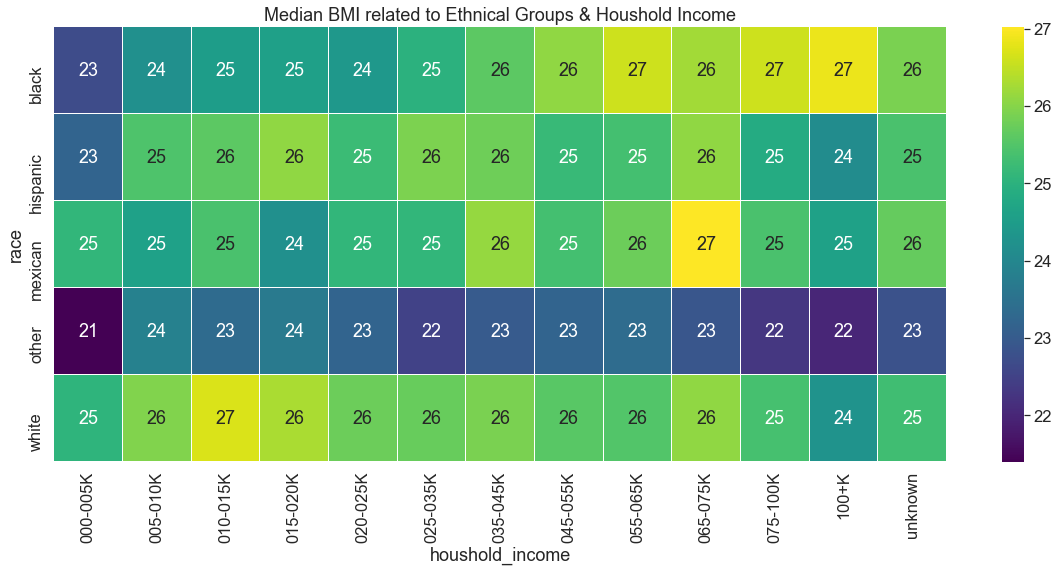

In [40]:
# Generate heatmap showing the median bmi for each income level an ethnic group.
fig, ax = plt.subplots(figsize=(20,8)) 
sns.heatmap(df_bmi_income_race_median.drop(['<020K','>020K'], axis=1), ax=ax, cmap='viridis',
            linewidth=0.1, annot=True).set_title('Median BMI related to Ethnical Groups & Houshold Income')

In [41]:
df_bmi_income_race_cluster = df_bmi_income_race_median.drop(['<020K','>020K','unknown'], axis=1)

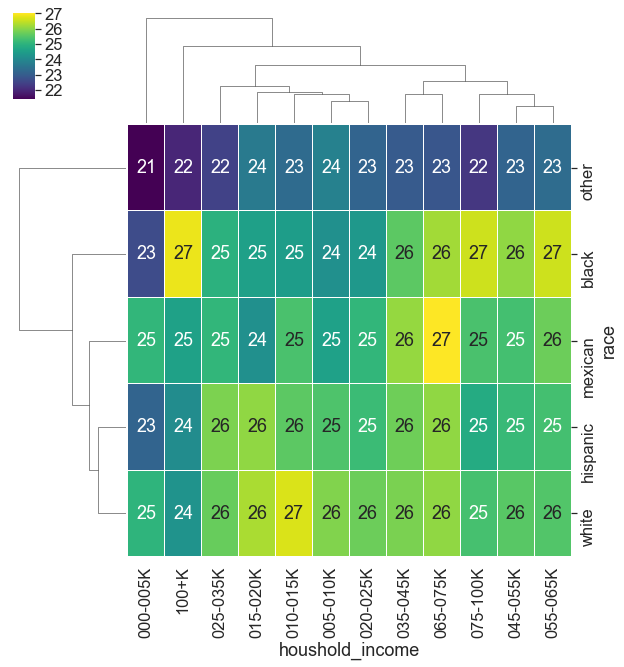

In [42]:
sns.clustermap(df_bmi_income_race_cluster, cmap='viridis', linewidth=0.1, annot=True)

In [54]:
# For the bmi group counting we do not need the exact bmi.
df_bmi_income_race_stats = df_bmi_income_race.drop('bmi', axis=1).copy()
# Aggregate the bmi group counts for each income level (separated by ethnic group).
df_bmi_income_race_stats = df_bmi_income_race_stats.groupby(['race','houshold_income','bmi_group']).count()
df_bmi_income_race_stats = df_bmi_income_race_stats.reset_index()
# Rename the columns of the new dataframe for easier reding.
df_bmi_income_race_stats.rename(columns={'id':'count','bmi_group':'bmi'}, inplace=True)
df_bmi_income_race_stats.head()

race houshold_income    bmi  count
0  black        000-005K  10-18    119
1  black        000-005K  18-25    124
2  black        000-005K  25-30     56
3  black        000-005K  30-35     46
4  black        000-005K  35-40     20

In [62]:
def extract_race_bmi_income_heatmap_table(dataframe, race):
    df_race_stats = dataframe[dataframe['race'] == race].copy()
    df_race_stats = df_race_stats.drop('race', axis=1)
    df_race_stats = df_race_stats.pivot(values='count', index='bmi', columns='houshold_income')
    df_race_stats = df_race_stats.fillna(0)
    df_race_stats = calculate_column_total(df_race_stats)
    df_race_percent = calculate_column_percentage_table(df_race_stats)
    df_race_percent['race'] = race
    df_race_percent = df_race_percent.drop('col_total', axis=0)
    return df_race_percent

In [63]:
# Calculate a bmi group percentage distribution for each ethnic group.
df_bmi_income_black_percent = extract_race_bmi_income_heatmap_table(df_bmi_income_race_stats, 'black')
df_bmi_income_mexican_percent = extract_race_bmi_income_heatmap_table(df_bmi_income_race_stats, 'mexican')
df_bmi_income_hispanic_percent = extract_race_bmi_income_heatmap_table(df_bmi_income_race_stats, 'hispanic')
df_bmi_income_white_percent = extract_race_bmi_income_heatmap_table(df_bmi_income_race_stats, 'white')
df_bmi_income_other_percent = extract_race_bmi_income_heatmap_table(df_bmi_income_race_stats, 'other')
# Merge all ethnic group tables by appending.
df_bmi_income_race_percent = df_bmi_income_black_percent
df_bmi_income_race_percent = df_bmi_income_race_percent.append(df_bmi_income_mexican_percent)
df_bmi_income_race_percent = df_bmi_income_race_percent.append(df_bmi_income_hispanic_percent)
df_bmi_income_race_percent = df_bmi_income_race_percent.append(df_bmi_income_white_percent)
df_bmi_income_race_percent = df_bmi_income_race_percent.append(df_bmi_income_other_percent)
# Show one result for better understanding.
df_bmi_income_black_percent

houshold_income  000-005K  005-010K  010-015K  015-020K  020-025K  025-035K  \
bmi                                                                           
10-18            0.303571  0.255023  0.258355  0.290141  0.243787  0.221239   
18-25            0.316327  0.281298  0.249357  0.233803  0.278107  0.276750   
25-30            0.142857  0.160742  0.204370  0.194366  0.203550  0.206758   
30-35            0.117347  0.148377  0.146530  0.139437  0.120710  0.142397   
35-40            0.051020  0.066461  0.074550  0.071831  0.072189  0.076428   
40+              0.068878  0.088099  0.066838  0.070423  0.081657  0.076428   

houshold_income  035-045K  045-055K  055-065K  065-075K  075-100K     100+K  \
bmi                                                                           
10-18            0.188950  0.176316  0.160075  0.180180  0.181347  0.166667   
18-25            0.285083  0.267105  0.273070  0.263514  0.255181  0.249455   
25-30            0.223204  0.214474  0.239171  0.240991  0.198187  0.240741   
30-35            0.148066  0.164474  0.158192  0.175676  0.193005  0.184096   
35-40            0.077348  0.088158  0.092279  0.081081  0.090674  0.086057   
40+              0.077348  0.089474  0.077213  0.058559  0.081606  0.072985   

houshold_income     <020K     >020K   unknown   race  
bmi                                                   
10-18            0.268421  0.095930  0.158940  black  
18-25            0.331579  0.264535  0.304636  black  
25-30            0.189474  0.238372  0.231788  black  
30-35            0.100000  0.223837  0.174393  black  
35-40            0.057895  0.093023  0.088300  black  
40+              0.052632  0.084302  0.041943  black

#### Heatmap des Median BMI nach Alter und ethnischer Gruppe    
Wird die Beziehung von ethnischer Gruppenzugehörigkeit und BMI weiter nach Altersgruppe aufgespalten, dann erschein die Tendenz zum Übergewicht bei den weißen und mexikanischen Amerikanern eher ein Altersproblem. Bei Afroamerikanern hingegen findet sich der Hotspot in den jüngerem Jahren von 35-40. Dies kehrt die Beobachtung der zuvor erfolgten Aufteilung nach Einkommen geradezu um. Interessant wäre demnach eine Verknüpfung von Alter und Einkommen nach Ethnie. Eventuell gibt es in der afroamerikanischen Bevölkerung gleichsam eine Verschiebung der höheren Einkommen in jüngere Altersklassen. Auf einen so gearteten Test soll in dieser Arbeit jedoch verzichtet werden.

In [51]:
# Select bmi, race and age columns from the categorized dataframe.
df_bmi_age_race = df_categ[['KG_M2_bmi','CAT2_race','CAT1_age']]
df_bmi_age_race = df_bmi_age_race.dropna()
# Rename the columns of the new dataframe for easier reding.
df_bmi_age_race.rename(columns={'KG_M2_bmi':'bmi',
                                'CAT2_race':'race',
                                'CAT1_age':'age'}, inplace=True)

In [52]:
df_bmi_age_race = df_bmi_age_race.groupby(['race','age']).median()
df_bmi_age_race = df_bmi_age_race.reset_index()
df_bmi_age_race = df_bmi_age_race.pivot(values='bmi', index='race', columns='age')
df_bmi_age_race = df_bmi_age_race.drop(['01-04','05-09','10-14'], axis=1)

Text(0.5,1,'Median BMI related to Ethnical & Age Groups')

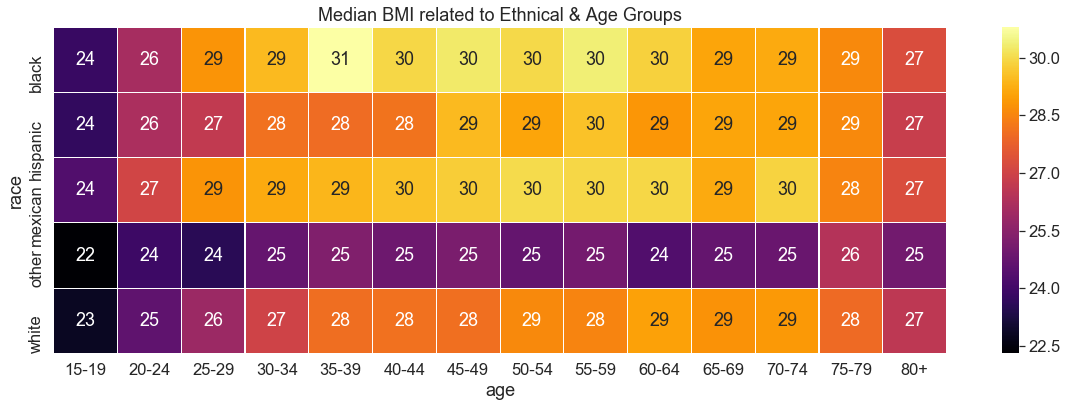

In [53]:
title_bmi_age_race = 'Median BMI related to Ethnical & Age Groups'
fig, ax = plt.subplots(figsize=(20,6)) 
sns.heatmap(df_bmi_age_race, ax=ax, cmap='inferno', linewidth=0.1, annot=True).set_title(title_bmi_age_race)